In [330]:
import numpy as np
import random as r
uniform_=r.uniform
gauss_=r.gauss
def uniform(a=0, b=1):
    return uniform_(a, b)
def gauss():
    ret=-1
    while ret<0 or ret>1:
        ret=gauss_(.5, 0.15)
    return ret

def dot6(nums):
    nums*=10**6
    nums=np.floor(nums)
    nums/=10**6
    return nums
def norm(data):
    for i in range(len(data[0])):
        dmin=min(data[:, i])
        dmax=max(data[:, i])
        dd=dmax-dmin
        data[:,i]-=dmin
        data[:, i]/=dd
    return data
def dot6_norm(data):
    data=dot6(data)
    data=norm(data)
    return data

def gen_pdt_uni(n, d):
    ret=[]
    for i in range(n):
        ret.append([uniform() for _ in range(d)])
    return ret

def gen_pdt_anti(n, d):
#     ret =[sample_point_uni(d) for _ in range(n)]
    # TODO more than 2 dimension
    means=[.5, .5]
    cov=[[1, -.95], [-.95, 1]]
    ret=np.random.multivariate_normal(means, cov, n)
    for i in range(d):
        dmin=min(ret[:, i])
        dmax=max(ret[:, i])
        ret[:,i]-=dmin
        ret[:,i]/=(dmax-dmin)
    return ret
def gen_pdt_corr(n, d):
    mean=[.5 for _ in range(d)]
    cov=[]
    for i in range(d):
        tmp=[]
        for j in range(d):
            if i==j:
                tmp.append(1)
            else:
                tmp.append(.95)
        cov.append(tmp)
    data = np.random.multivariate_normal(mean, cov, n)
    data=dot6_norm(data)
    return data
def gen_pdt_spherical(n, d):
    """
    here we use reject sampling
    """
    ret=set()
    while len(ret)<n:
        pdt=[uniform() for _ in range(d)]
        l2=LA.norm(pdt, 2)
        if l2>=0.8 and l2<=1.0:
            ret.add(tuple(pdt))
    return [list(pdt) for pdt in ret]

In [160]:
import matplotlib.pyplot as plt
import numpy as np

def plot_user(user, save=False, fn='', format='pdf', label=['p[1]', 'p[2]'], s=32):
    fig, ax = plt.subplots()
    user_a = np.array(user).T
    ax.scatter(user_a[0], user_a[1], s=s, facecolors='none', edgecolors='blue')
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.set_aspect('equal', 'box')
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])
    if save:
        plt.savefig(fn + '.'+format, format=format, bbox_inches='tight')
        plot_user(user)
    else:
        plt.show()

def plot_pdt(pdt, save=False, fn='', format='pdf', s=32):
    plot_user(pdt, save, fn, format=format,label=['w[1]', 'w[2]'], s=s)

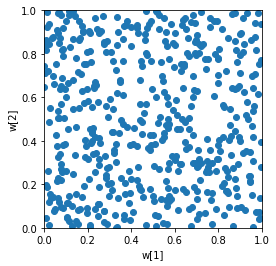

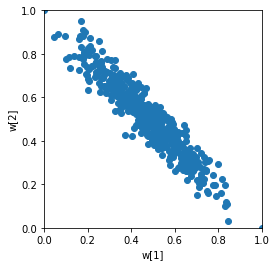

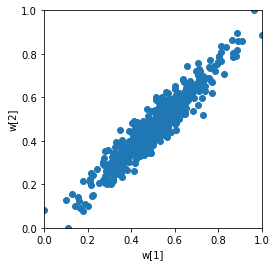

In [310]:
cardD=500

pdt_uni=gen_pdt_uni(cardD, 2)
pdt_anti=gen_pdt_anti(cardD, 2)
pdt_corr=gen_pdt_corr(cardD, 2)
plot_pdt(pdt_uni)
plot_pdt(pdt_anti)
plot_pdt(pdt_corr)

In [31]:
def dot(a1, a2):
    ret=0.0
    for i,j in zip(a1, a2):
        ret+=i*j
    return ret

DOMINATE=1
DOMINATED=-1
NONDO=0
def rDominate(vs, p1, p2):
    ret=NONDO
    for v in vs:
        p1s=dot(v, p1)
        p2s=dot(v, p2)
        if p1s>p2s:
            if ret==DOMINATED:
                return NONDO
            else:
                ret=DOMINATE
        elif p1s<p2s:
            if ret==DOMINATE:
                return NONDO
            else:
                ret=DOMINATED
    return ret

In [179]:

from scipy.optimize import linprog 
from numpy import linalg as LA

EPS=1e-5
def cell_rec_str(c):
    print(c)
    if len(c.children)>0:
        print(len(c.children))
        for i in c.children:
            cell_rec_str(i)
        print()

        
class cell:
    def choose2bound(self, choose):
        b=[]
        dim=int(len(choose))
        for i in range(dim):
            l=self.bounds[i*2]
            u=self.bounds[i*2+1]
            if choose[i]==0:
                b.append(l)
                b.append((l+u)/2.0)
            else:
                b.append((l+u)/2.0)
                b.append(u)
        return b
                
        
    def __init__(self, b, cur_level, tar_level, L2norm=False):
        self.children=[]
        self.r_kskyband=[]
        dim=int(len(b)/2)
        self.bounds=b
        self.uHeat=0.0    #  the k_th minimun score
        self.rHeat=0      #  No. of RSC
        self.dHeat=0      #  No. of r-dominate relationships
        self.L2=L2norm
        if cur_level<tar_level:
            if dim>=3:
                choose=[0 for _ in range(dim)]
                self.children.append(cell(self.choose2bound(choose), cur_level+1, tar_level, L2norm))
            for i in range(dim):
                choose=[0 for _ in range(dim)]
                choose[i]=1
                self.children.append(cell(self.choose2bound(choose), cur_level+1, tar_level, L2norm))
        if L2norm:
            self.circle2cartesian()
        self.get_vertexes()
    
    def circle2cartesian(self):
        # BE CAREFUL!!! Only for 2D!!!
        l=self.bounds[0]
        u=self.bounds[1]
#         print(l, u)
        xl=np.cos(u)
        yl=np.sin(l)
        xu=np.cos(l)
        yu=np.sin(u)
        tmp=sum([xl, yu])
        xl/=tmp
        yu/=tmp
        tmp=sum([xu, yl])
        xu/=tmp
        yl/=tmp
        self.bounds=[xl, xu, yl, yu]
    
    def __str__(self):
        dim=int(len(self.bounds)/2)
        s='['
        for i in range(dim):
            s+=self.bounds[i*2:i*2+2].__str__()+','
        s+=']'
        return s
    
    def get_vertexes(self):
        self.vertexes=[]
        dim=int(len(self.bounds)/2)
        for i in range(dim):
            choose=[0 for _ in range(dim)]
            choose[i]=1
            v=[]
            for j in range(dim):
                l=self.bounds[j*2]
                u=self.bounds[j*2+1]
                if choose[j]==0:
                    v.append(l)
                else:
                    v.append(u)
            self.vertexes.append(v)
    
    def minu(self, p):
        dim=int(len(self.bounds)/2)
        b=[]
        for i in range(dim):
            b.append(tuple(self.bounds[i*2:i*2+2]))
        A_eq=[[1.0 for _ in range(dim)]]
        b_eq=[1.0]
        return linprog(p, bounds=b, A_eq=A_eq, b_eq=b_eq,options={"disp": False}).fun
    
    def utility_heats(self, pdts, k, re_cp_rsky=True):
        self.uHeat=0.0
        if len(pdts)<k:
            return
        if re_cp_rsky:
            self.competition_heats(pdts, k)
        if len(self.r_kskyband)<k:
            return
        vals=[]
        if not self.L2:
            for pdt in self.r_kskyband:
                vals.append(self.minu(pdt))
        else:
            for pdt in self.r_kskyband:
                ss=[]
                for v in self.vertexes:
                    vL2=LA.norm(v, 2)
                    vnew=[i/vL2 for i in v]
                    s=dot(pdt, vnew)
                    ss.append(s)
                vals.append(min(ss))
        ret=sorted(vals, reverse=True)
        self.uHeat=ret[k-1]
#         print('u of ', self.bounds)
#         print(ret)
    
    def competition_heats(self, pdts, k):
        if len(self.vertexes)==0:
            self.get_vertexes()
        self.r_kskyband=[]
        self.dHeat=0
        doed_cnt=[0 for _ in range(len(pdts))]
        for i in range(len(pdts)):
            for j in range(i+1, len(pdts)):
                rd=rDominate(self.vertexes, pdts[i], pdts[j])
                if rd!=NONDO:
                    if rd==DOMINATE:
                        doed_cnt[j]+=1
                    else:
                        doed_cnt[i]+=1
        for i in range(len(doed_cnt)):
            if doed_cnt[i]<k:
                self.r_kskyband.append(pdts[i])
                self.dHeat+=doed_cnt[i]
        self.rHeat=len(self.r_kskyband)
                    


In [342]:

root=cell([0.0, 1.0, 0.0, 1.0], 0, 6)
print('-'*50)
cell_rec_str(root)

[[0.984375, 1.0],[0.0, 0.015625],]
[[0.984375, 1.0],[0.0, 0.015625],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.90625],[0.09375, 0.125],]
[[0.875, 0.90625],[0.09

In [33]:
def get_leaf_c(r, ret):
    if len(r.children)==0:
        ret.append(r)
    else:
        for i in r.children:
            get_leaf_c(i, ret)

16


In [34]:
def cal_uHeat(cells, pdts, k):
    for c in cells:
        c.utility_heats(pdts, k)
        
def cal_cHeat(cells, pdts, k):
    for c in cells:
        c.competition_heats(pdts, k)
        
def cal_heat(cells, pdts, k):
    cal_uHeat(cells, pdts, k)

In [35]:
def get_all_heat(cells, heat='utility'):
    all_h=[]
    if heat=='utility':
        all_h=[c.uHeat for c in cells]
    elif heat=='rkskyband':
        all_h=[c.rHeat for c in cells]
    elif heat=='rdominate':
        all_h=[c.dHeat for c in cells]
    else:
        print('only support \'utility\', \'rkskyband\', \'rdominate\'')
    return all_h

import matplotlib.colors as colors
from matplotlib import cm

def draw2d_heat(cells, heats, vmin=None, vmax=None, f=None):
    """
    heat='utility' or heat='rkskyband' or heat='rdominate', the default is heat='utility'
    """
    # TODO1 how to define heatmap color and the normalize range
    # TODO2 how to plot ploygon on 2d and 3d

    if vmin is None:
        vmin=min(heats)
    if vmax is None:
        vmax=max(heats)
    normH=[(h-vmin)/(vmax-vmin) for h in heats]
#     print('before normalize: ', heats)
#     print('after normalize: ', normH)
#     cdict = {'red':   [(0.0,  0.0, 0.0),
#                                (0.5,  0.5, 0.5),
#                                (1.0,  1.0, 1.0)],

#                      'green': [(0.0,  0.0, 0.0),
#                                (0.25, 0.0, 0.0),
#                                (0.75, 0.0, 0.0),
#                                (1.0,  0.0, 0.0)],

#                      'blue':  [(0.0,  1.0, 1.0),
#                                (0.5,  0.5, 0.5),
#                                (1.0,  0.0, 0.0)]}
    
#     cobj=colors.LinearSegmentedColormap(name='rainbow', segmentdata=cdict)
#     cs=cobj.__call__(normH) # colors
    
    fig, ax = plt.subplots()
    ax.set_xlabel('w[1]')
    ax.set_ylabel('w[2]')
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.set_aspect('equal', 'box')
    mycm= cm.get_cmap('rainbow', 256)
    for cell,h in zip(cells, normH):
        x=[v[0] for v in cell.vertexes]
        y=[v[1] for v in cell.vertexes]
#         print(h, cell.vertexes)
        ax.plot(x, y, color=mycm(h))
    if not f:
        plt.show()
    else:
        plt.savefig(f, format='png',  bbox_inches='tight')
        draw2d_heat(cells, heats, vmin=vmin, vmax=vmax)

    

In [343]:
all_c=[]
get_leaf_c(root, all_c)
print(len(all_c))

64


In [344]:
cal_heat(all_c, pdt_uni, 5)

before normalize:  [0.9861310798675317, 0.9780719027763899, 0.9686457691311134, 0.9674962139447759, 0.9670333486916813, 0.9663903571569473, 0.9626862965247339, 0.9591179404760993, 0.9576629899317632, 0.9562080393874272, 0.9547530888430911, 0.9532981382987551, 0.9503633419835229, 0.9468943761016071, 0.9442374889201582, 0.945154740832222, 0.9460233855770748, 0.9445684350327388, 0.9431134844884027, 0.9416585339440666, 0.9402035833997306, 0.9387486328553947, 0.9372936823110586, 0.9358387317667225, 0.9343837812223864, 0.9337397849114455, 0.9345290752044071, 0.9353183654973687, 0.9361076557903305, 0.9368969460832921, 0.9376862363762539, 0.9384755266692155, 0.9392648169621771, 0.9400541072551389, 0.9408433975481005, 0.9416326878410622, 0.942421978134024, 0.9432112684269855, 0.9440005587199474, 0.944789849012909, 0.9463011898461788, 0.9479664160161956, 0.9494444690740884, 0.9489816038209938, 0.9487363004777174, 0.949525590770679, 0.9503148810636407, 0.9511041713566024, 0.951893461649564, 0.952

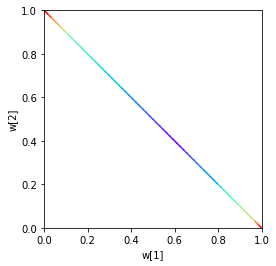

before normalize:  [7, 6, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 8]
after normalize:  [0.6666666666666666, 0.3333333333333333, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 1.0]
0.6666666666666666 [[1.0, 0.0], [0.984375, 0.015625]]
0.3333333333333333 [[0.984375, 0.015625], [0.96875, 0.03125]]
0.0 [[0.96875, 0.03125], [0.953125, 0.046875]]
0.3333333333333333 [[0.953125, 0.046875], [0.9375, 0.0625]]
0.0 [[0.9375, 0.0625], [0.92187

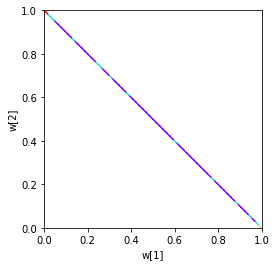

before normalize:  [14, 11, 9, 14, 10, 9, 10, 14, 9, 10, 10, 10, 8, 10, 14, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 9, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 14, 10, 10, 9, 10, 14, 9, 10, 14, 13, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 8, 10, 13, 5, 17]
after normalize:  [0.75, 0.5, 0.3333333333333333, 0.75, 0.4166666666666667, 0.3333333333333333, 0.4166666666666667, 0.75, 0.3333333333333333, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.25, 0.4166666666666667, 0.75, 0.4166666666666667, 0.3333333333333333, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.75, 0.4166666666666667, 0.3333333333333333, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.3333333333333333, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.75, 0.4166666666666667, 0.4166666

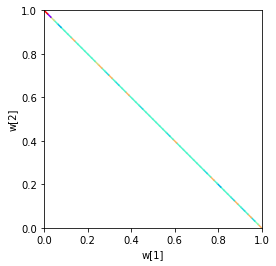

In [345]:
uheats=get_all_heat(all_c)
draw2d_heat(all_c, uheats)

rheats=get_all_heat(all_c, heat='rkskyband')
draw2d_heat(all_c, rheats)

dheats=get_all_heat(all_c, heat='rdominate')
draw2d_heat(all_c, dheats)

In [236]:
all_c=[]
get_leaf_c(root, all_c)
print(len(all_c))

16


In [278]:
cal_heat(all_c, pdt_corr, 5)

before normalize:  [0.8408661706854222, 0.8410191436555926, 0.8411721166257632, 0.8413250895959337, 0.8414780625661041, 0.8416310355362746, 0.8417840085064452, 0.8419855848023279, 0.8426397288422864, 0.8432938728822448, 0.8439480169222033, 0.8446021609621618, 0.8452563050021203, 0.8459104490420788, 0.8465645930820372, 0.8472187371219958, 0.8478728811619543, 0.8485270252019127, 0.8491811692418713, 0.8498353132818298, 0.8504894573217883, 0.8511436013617468, 0.8517977454017053, 0.8524518894416637, 0.8531060334816223, 0.8537601775215806, 0.8544143215615392, 0.8550684656014977, 0.8557226096414562, 0.8563767536814146, 0.8570308977213732, 0.8576850417613318, 0.8583391858012902, 0.8588137572923822, 0.8591612363425232, 0.8595087153926639, 0.8598561944428049, 0.8602036734929457, 0.8605511525430867, 0.8608986315932277, 0.8612461106433684, 0.8615935896935094, 0.8619410687436502, 0.8622885477937912, 0.862636026843932, 0.8629835058940729, 0.8633309849442138, 0.8636784639943547, 0.8640259430444955, 0

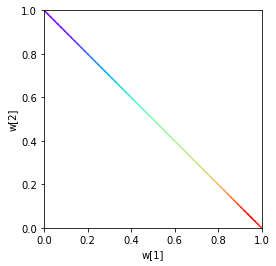

before normalize:  [5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
after normalize:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0 [[0.0, 1.0], [0.015625, 0.984375]]
0.0 [[0.015625, 0.984375], [0.03125, 0.96875]]
0.0 [[0.03125, 0.96875], [0.046875, 0.953125]]
0.0 [[0.046875, 0.953125], [0.0625, 0.9375]]
0.0 [[0.0625, 0.9375], [0.078125, 0.921875]]
0.0 [[0.078125, 0.921875], [0.09375, 0.90625]]
1.0 [[0.09375, 0.90625], [0.109375, 0.890625]]
0.0 [[0.109375, 0.890625], [0.125, 0.875]]
0.0 [[0.125, 0.875], [0.140625, 0.859375]]
0.0 [[0.140625, 0.859375], [0.15625, 0.84375]]

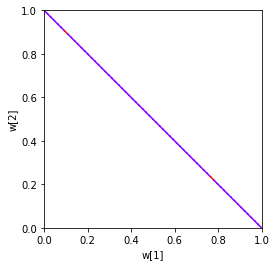

before normalize:  [10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10]
after normalize:  [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.2, 0.2]
0.2 [[0.0, 1.0], [0.015625, 0.984375]]
0.2 [[0.015625, 0.984375], [0.03125, 0.96875]]
0.2 [[0.03125, 0.96875], [0.046875, 0.953125]]
0.2 [[0.046875, 0.953125], [0.0625, 0.9375]]
0.2 [[0.0625, 0.9375], [0.078125, 0.921875]]
0.2 [[0.078125, 0.921875], [0.09375, 0.90625]]
1.0 [[0.09375, 0.90625], [0.109375, 0.890625]]
0.2 [[0.109375, 0.890625], [0.125, 0.875]]
0.2 [[0.125, 0.875], [0.14062

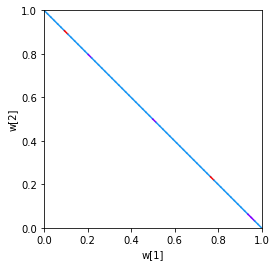

In [279]:
uheats=get_all_heat(all_c)
draw2d_heat(all_c, uheats)

rheats=get_all_heat(all_c, heat='rkskyband')
draw2d_heat(all_c, rheats)

dheats=get_all_heat(all_c, heat='rdominate')
draw2d_heat(all_c, dheats)

In [260]:
all_c=[]
get_leaf_c(root, all_c)
print(len(all_c))

64


In [280]:
cal_heat(all_c, pdt_anti, 5)

before normalize:  [0.8512799809885658, 0.84194300440447, 0.8326060278203742, 0.8232690512362782, 0.8139320746521824, 0.8045950980680865, 0.7952581214839906, 0.7859211448998947, 0.7765841683157988, 0.767247191731703, 0.757910215147607, 0.7485732385635112, 0.7392362619794153, 0.7298992853953195, 0.7205623088112236, 0.7112253322271276, 0.7018431458345114, 0.6902901511072084, 0.6787371563799052, 0.6671841616526022, 0.6572309237833212, 0.6508280652582777, 0.6406250000006585, 0.6317056456198775, 0.6260315224496865, 0.6178555663861689, 0.608518589802073, 0.599181613217977, 0.5898446366338812, 0.5811995528393564, 0.5787693437873627, 0.5777210254142424, 0.5773724175173732, 0.5758685313647315, 0.5773773799466205, 0.5806905542304481, 0.5870001369682845, 0.5940354609687579, 0.5996193024439571, 0.6092106369099569, 0.6198689667884624, 0.6277538058598299, 0.6367369029147608, 0.64727993246245, 0.6578229620101391, 0.668263645799372, 0.6796344560495828, 0.6924426121382589, 0.7055510699123362, 0.7185321

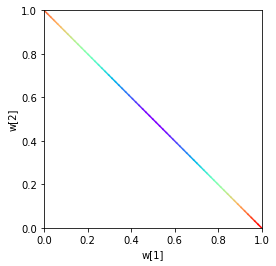

before normalize:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 7, 5, 5, 5, 5, 5, 7, 5, 7, 6, 6, 7, 5, 6, 6, 6, 6, 6, 6, 5, 5, 7, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
after normalize:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.5, 0.5, 1.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 1.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0 [[0.0, 1.0], [0.015625, 0.984375]]
0.0 [[0.015625, 0.984375], [0.03125, 0.96875]]
0.0 [[0.03125, 0.96875], [0.046875, 0.953125]]
0.0 [[0.046875, 0.953125], [0.0625, 0.9375]]
0.0 [[0.0625, 0.9375], [0.078125, 0.921875]]
0.0 [[0.078125, 0.921875], [0.09375, 0.90625]]
0.0 [[0.09375, 0.90625], [0.109375, 0.890625]]
0.0 [[0.109375, 0.890625], [0.125, 0.875]]
0.0 [[0.125, 0.875], [0.140625, 0.859375]]
0.0 [[0.140625, 0.859375], [0.15625, 0.84375]]

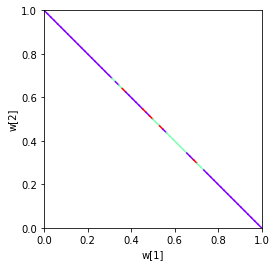

before normalize:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 9, 10, 10, 9, 13, 9, 10, 18, 8, 9, 8, 9, 10, 17, 10, 17, 7, 10, 16, 8, 12, 14, 14, 10, 13, 13, 10, 10, 17, 13, 14, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
after normalize:  [0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.18181818181818182, 0.2727272727272727, 0.2727272727272727, 0.18181818181818182, 0.2727272727272727, 0.2727272727272727, 0.18181818181818182, 0.5454545454545454, 0.18181818181818182, 0.2727272727272727, 1.0, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727, 0.9090909090909091, 0.2727272727272727, 0.9090909090909091, 0.0, 0.2727272727272727, 0.8181818181818182, 0.09090909090909091, 0.454545454545454

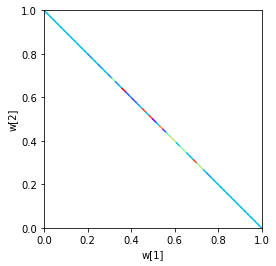

In [281]:
uheats=get_all_heat(all_c)
draw2d_heat(all_c, uheats)

rheats=get_all_heat(all_c, heat='rkskyband')
draw2d_heat(all_c, rheats)

dheats=get_all_heat(all_c, heat='rdominate')
draw2d_heat(all_c, dheats)

In [288]:
def draw2d_heatL2(cells, heats, vmin=None, vmax=None, f=None):
    """
    heat='utility' or heat='rkskyband' or heat='rdominate', the default is heat='utility'
    """
    # TODO1 how to define heatmap color and the normalize range
    # TODO2 how to plot ploygon on 2d and 3d

    if vmin is None:
        vmin=min(heats)
    if vmax is None:
        vmax=max(heats)
    normH=[(h-vmin)/(vmax-vmin) for h in heats]
    print('before normalize: ', heats)
    print('after normalize: ', normH)
#     cdict = {'red':   [(0.0,  0.0, 0.0),
#                                (0.5,  0.5, 0.5),
#                                (1.0,  1.0, 1.0)],

#                      'green': [(0.0,  0.0, 0.0),
#                                (0.25, 0.0, 0.0),
#                                (0.75, 0.0, 0.0),
#                                (1.0,  0.0, 0.0)],

#                      'blue':  [(0.0,  1.0, 1.0),
#                                (0.5,  0.5, 0.5),
#                                (1.0,  0.0, 0.0)]}
    
#     cobj=colors.LinearSegmentedColormap(name='rainbow', segmentdata=cdict)
#     cs=cobj.__call__(normH) # colors
    
    fig, ax = plt.subplots()
    ax.set_xlabel('w[1]')
    ax.set_ylabel('w[2]')
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.set_aspect('equal', 'box')
    mycm= cm.get_cmap('rainbow', 256)
    for cell,h in zip(cells, normH):
        x=[v[0] for v in cell.vertexes]
        y=[v[1] for v in cell.vertexes]
        x[0]/=LA.norm([x[0], y[0]], 2)
        x[1]/=LA.norm([x[1], y[1]], 2)
        angle1=np.arccos(x[0])
        angle2=np.arccos(x[1])
        x=[np.cos(angle2+(angle1-angle2)/100*i) for i in range(101)]
        y=[np.sin(angle2+(angle1-angle2)/100*i) for i in range(101)]
        ax.plot(x, y, color=mycm(h))
    if not f:
        plt.show()
    else:
        plt.savefig(f, format='png',  bbox_inches='tight')
        draw2d_heat(cells, heats, vmin=vmin, vmax=vmax)

In [315]:

root=cell([0.0, np.pi/2, 0.0, np.pi/2], 0, 6, L2norm=True)
print('-'*50)
cell_rec_str(root)

all_c=[]
get_leaf_c(root, all_c)
print(len(all_c))



[[0.0, 0.02454369260617026],[0.9754563073938297, 1.0],]
0.0 0.02454369260617026
[[0.9760395733504628, 1.0],[0.0, 0.023960426649537327],]
[[0.02454369260617026, 0.04908738521234052],[0.9509126147876594, 0.9754563073938297],]
0.02454369260617026 0.04908738521234052
[[0.9531735845095735, 0.9760395733504628],[0.023960426649537327, 0.04682641549042642],]
[[0.0, 0.04908738521234052],[0.9509126147876594, 1.0],]
0.0 0.04908738521234052
[[0.9531735845095735, 1.0],[0.0, 0.04682641549042642],]
[[0.04908738521234052, 0.07363107781851078],[0.9263689221814893, 0.9509126147876594],]
0.04908738521234052 0.07363107781851078
[[0.93130296612837, 0.9531735845095735],[0.04682641549042642, 0.06869703387163006],]
[[0.07363107781851078, 0.09817477042468103],[0.901825229575319, 0.9263689221814893],]
0.07363107781851078 0.09817477042468103
[[0.9103393954143301, 0.93130296612837],[0.06869703387163006, 0.08966060458566982],]
[[0.04908738521234052, 0.09817477042468103],[0.901825229575319, 0.9509126147876594],]
0.0

In [316]:
cal_heat(all_c, pdt_uni, 5)

before normalize:  [0.9934438562399394, 1.0062846094285145, 1.015038900571359, 1.0358515913859005, 1.0567890873787438, 1.0731782134038395, 1.0890271968364713, 1.1065088173548956, 1.1233239183367747, 1.1394623709940346, 1.1535592806498363, 1.1656883615711304, 1.1787012464486084, 1.1949630292555171, 1.2096792538823324, 1.2215683328090654, 1.2327215846494965, 1.2431322911017635, 1.2527941811455814, 1.2617014348196687, 1.2698486867274765, 1.2772310292691, 1.2838440155974362, 1.2896836622967964, 1.2958292539123375, 1.302658401222105, 1.3087028758205115, 1.3139590367420764, 1.3184237178720004, 1.3220942298533171, 1.324968361706857, 1.327044382163063, 1.3283210407048396, 1.3284736779685824, 1.3273495647475686, 1.3254259057815472, 1.3227038598107506, 1.319185066493887, 1.3148716454204736, 1.309766194834077, 1.3038840699329823, 1.2982012388043525, 1.291736419792338, 1.2844935070621761, 1.2752142746092308, 1.2639502378185286, 1.252169128732889, 1.240877768621185, 1.2288389501410713, 1.2160599250

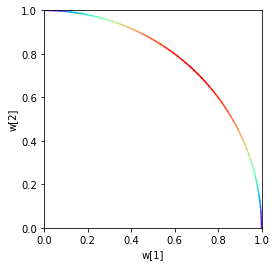

before normalize:  [7, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 7, 9]
after normalize:  [0.5, 0.0, 0.25, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0]


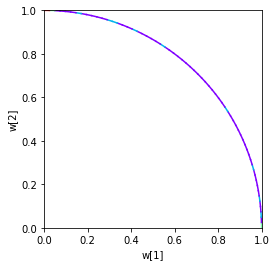

before normalize:  [10, 9, 14, 10, 9, 14, 9, 10, 10, 8, 10, 14, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 14, 10, 10, 10, 9, 10, 14, 9, 10, 10, 13, 14, 10, 10, 10, 10, 10, 14, 10, 10, 9, 9, 14, 14]
after normalize:  [0.3333333333333333, 0.16666666666666666, 1.0, 0.3333333333333333, 0.16666666666666666, 1.0, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.0, 0.3333333333333333, 1.0, 0.3333333333333333, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.333

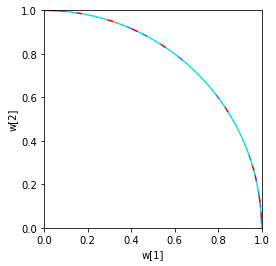

In [317]:
uheats=get_all_heat(all_c)
draw2d_heatL2(all_c, uheats)

rheats=get_all_heat(all_c, heat='rkskyband')
draw2d_heatL2(all_c, rheats)

dheats=get_all_heat(all_c, heat='rdominate')
draw2d_heatL2(all_c, dheats)

before normalize:  [0.8724908525040832, 0.8953500620537022, 0.9175384331702074, 0.9361858137761109, 0.9542692710540382, 0.9717779122055086, 0.9887011906797832, 1.005028912526711, 1.0207512425371843, 1.0358587101675005, 1.0503422152440638, 1.0641930334449892, 1.0781133767455322, 1.0914933033466363, 1.1042157551953675, 1.1162730687624556, 1.1276579811730598, 1.138363634581653, 1.1483835803029323, 1.157711782696265, 1.1663426228013336, 1.1742709017227861, 1.181491843761858, 1.1880010992930734, 1.1937947473842971, 1.198869298158557, 1.2032216948962167, 1.206849315876228, 1.209749975955358, 1.211921927884438, 1.21336386336084, 1.2138749155656599, 1.2127828207320879, 1.210960190876177, 1.2084081238820004, 1.2051281570192873, 1.20112226601743, 1.1963928638753787, 1.1909427994081392, 1.1847753555307556, 1.1778942472808045, 1.170303619580594, 1.1620080447404195, 1.1530125197043726, 1.1433224630403709, 1.132943711676214, 1.1218825173836375, 1.1101455430124785, 1.0977398584772242, 1.0846729364983

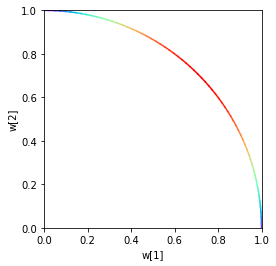

before normalize:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5]
after normalize:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


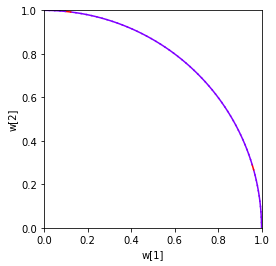

before normalize:  [10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10]
after normalize:  [0.2, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2, 0.2]


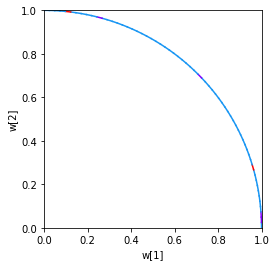

before normalize:  [0.8724908525040832, 0.8953500620537022, 0.9175384331702074, 0.9361858137761109, 0.9542692710540382, 0.9717779122055086, 0.9887011906797832, 1.005028912526711, 1.0207512425371843, 1.0358587101675005, 1.0503422152440638, 1.0641930334449892, 1.0781133767455322, 1.0914933033466363, 1.1042157551953675, 1.1162730687624556, 1.1276579811730598, 1.138363634581653, 1.1483835803029323, 1.157711782696265, 1.1663426228013336, 1.1742709017227861, 1.181491843761858, 1.1880010992930734, 1.1937947473842971, 1.198869298158557, 1.2032216948962167, 1.206849315876228, 1.209749975955358, 1.211921927884438, 1.21336386336084, 1.2138749155656599, 1.2127828207320879, 1.210960190876177, 1.2084081238820004, 1.2051281570192873, 1.20112226601743, 1.1963928638753787, 1.1909427994081392, 1.1847753555307556, 1.1778942472808045, 1.170303619580594, 1.1620080447404195, 1.1530125197043726, 1.1433224630403709, 1.132943711676214, 1.1218825173836375, 1.1101455430124785, 1.0977398584772242, 1.0846729364983

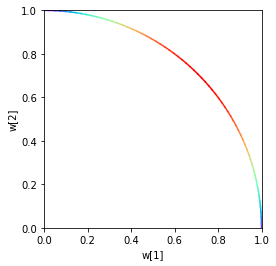

before normalize:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5]
after normalize:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


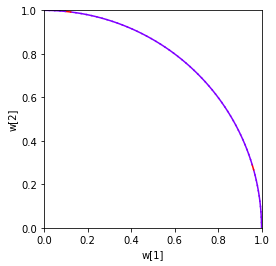

before normalize:  [10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10]
after normalize:  [0.2, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2, 0.2]


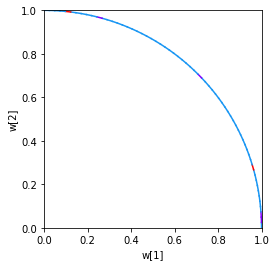

In [285]:
cal_heat(all_c, pdt_corr, 5)
uheats=get_all_heat(all_c)
draw2d_heatL2(all_c, uheats)

rheats=get_all_heat(all_c, heat='rkskyband')
draw2d_heatL2(all_c, rheats)

dheats=get_all_heat(all_c, heat='rdominate')
draw2d_heatL2(all_c, dheats)
uheats=get_all_heat(all_c)
draw2d_heatL2(all_c, uheats)

rheats=get_all_heat(all_c, heat='rkskyband')
draw2d_heatL2(all_c, rheats)

dheats=get_all_heat(all_c, heat='rdominate')
draw2d_heatL2(all_c, dheats)

before normalize:  [0.9070389879474829, 0.909287246624462, 0.9109877846645146, 0.9121395777271125, 0.9127419320151834, 0.9122972041048765, 0.9112503897939623, 0.9096546723220834, 0.9075110128897763, 0.9048207027573272, 0.9015853624669622, 0.8978069408666953, 0.8930382875192219, 0.8875023609459319, 0.8815384443385152, 0.8767726234682225, 0.8727472897543441, 0.868196245707241, 0.8631222327056723, 0.8575917993798767, 0.8539651633992579, 0.8504678891063098, 0.8444312312697269, 0.8348919272688802, 0.8315712778975255, 0.8281705362690736, 0.8234295587876868, 0.8186133933163554, 0.815162067053349, 0.8146393135795265, 0.8155728716370235, 0.8166415689059838, 0.8170209087293558, 0.8175201500930878, 0.8194812362829506, 0.8234841880346734, 0.8321433473452662, 0.8403012546192624, 0.8479529958383638, 0.8550939618797766, 0.8617198512925759, 0.8652853646788355, 0.8667149062812621, 0.8700869911087115, 0.8757157523228585, 0.8784169805815466, 0.8799211594227427, 0.8855570319138095, 0.8906594779619617, 0.8

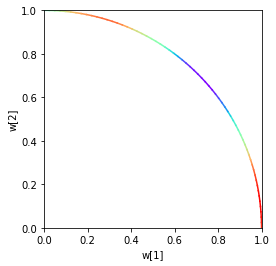

before normalize:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 5, 5, 6, 5, 6, 6, 6, 5, 6, 6, 5, 6, 7, 5, 6, 6, 6, 7, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
after normalize:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 1.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 1.0, 0.0, 0.5, 0.5, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


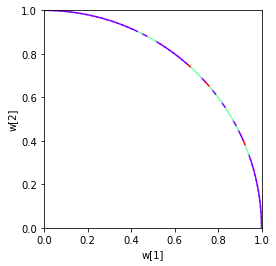

before normalize:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 14, 14, 16, 10, 10, 14, 8, 14, 10, 14, 10, 13, 13, 9, 12, 16, 7, 8, 13, 14, 16, 10, 10, 9, 8, 10, 8, 9, 14, 11, 8, 13, 9, 10, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
after normalize:  [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.2222222222222222, 0.3333333333333333, 0.7777777777777778, 0.7777777777777778, 1.0, 0.3333333333333333, 0.3333333333333333, 0.7777777777777778, 0.1111111111111111, 0.7777777777777778, 0.3333333333333333, 0.7777777777777778, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.2222222222222222, 0.5555555555555556, 1.0, 0.0, 0.1111111111111111, 0.6666666666666666, 0.7777777777777778, 1.0, 0.3333333333333333, 0.3333333333333333, 0.2222222222222222, 0.1111111111111111

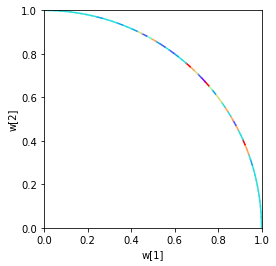

before normalize:  [0.9070389879474829, 0.909287246624462, 0.9109877846645146, 0.9121395777271125, 0.9127419320151834, 0.9122972041048765, 0.9112503897939623, 0.9096546723220834, 0.9075110128897763, 0.9048207027573272, 0.9015853624669622, 0.8978069408666953, 0.8930382875192219, 0.8875023609459319, 0.8815384443385152, 0.8767726234682225, 0.8727472897543441, 0.868196245707241, 0.8631222327056723, 0.8575917993798767, 0.8539651633992579, 0.8504678891063098, 0.8444312312697269, 0.8348919272688802, 0.8315712778975255, 0.8281705362690736, 0.8234295587876868, 0.8186133933163554, 0.815162067053349, 0.8146393135795265, 0.8155728716370235, 0.8166415689059838, 0.8170209087293558, 0.8175201500930878, 0.8194812362829506, 0.8234841880346734, 0.8321433473452662, 0.8403012546192624, 0.8479529958383638, 0.8550939618797766, 0.8617198512925759, 0.8652853646788355, 0.8667149062812621, 0.8700869911087115, 0.8757157523228585, 0.8784169805815466, 0.8799211594227427, 0.8855570319138095, 0.8906594779619617, 0.8

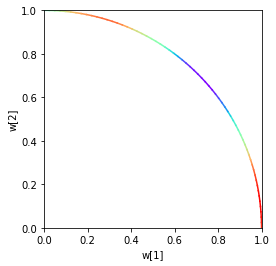

before normalize:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 5, 5, 6, 5, 6, 6, 6, 5, 6, 6, 5, 6, 7, 5, 6, 6, 6, 7, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
after normalize:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 1.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 1.0, 0.0, 0.5, 0.5, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


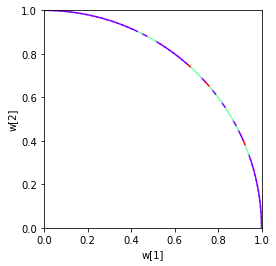

before normalize:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 14, 14, 16, 10, 10, 14, 8, 14, 10, 14, 10, 13, 13, 9, 12, 16, 7, 8, 13, 14, 16, 10, 10, 9, 8, 10, 8, 9, 14, 11, 8, 13, 9, 10, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
after normalize:  [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.2222222222222222, 0.3333333333333333, 0.7777777777777778, 0.7777777777777778, 1.0, 0.3333333333333333, 0.3333333333333333, 0.7777777777777778, 0.1111111111111111, 0.7777777777777778, 0.3333333333333333, 0.7777777777777778, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.2222222222222222, 0.5555555555555556, 1.0, 0.0, 0.1111111111111111, 0.6666666666666666, 0.7777777777777778, 1.0, 0.3333333333333333, 0.3333333333333333, 0.2222222222222222, 0.1111111111111111

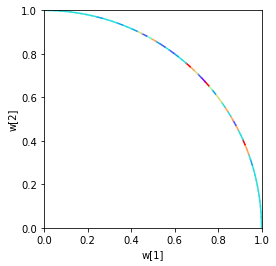

In [286]:
cal_heat(all_c, pdt_anti, 5)
uheats=get_all_heat(all_c)
draw2d_heatL2(all_c, uheats)

rheats=get_all_heat(all_c, heat='rkskyband')
draw2d_heatL2(all_c, rheats)

dheats=get_all_heat(all_c, heat='rdominate')
draw2d_heatL2(all_c, dheats)
uheats=get_all_heat(all_c)
draw2d_heatL2(all_c, uheats)

rheats=get_all_heat(all_c, heat='rkskyband')
draw2d_heatL2(all_c, rheats)

dheats=get_all_heat(all_c, heat='rdominate')
draw2d_heatL2(all_c, dheats)

In [178]:
def getHeats(all_c, pdt, k=5):
    cal_heat(all_c, pdt, k)
    uheats=get_all_heat(all_c)
    rheats=get_all_heat(all_c, heat='rkskyband')
    dheats=get_all_heat(all_c, heat='rdominate')
    return [uheats, rheats, dheats]

In [346]:
pl=6
def getHeats(all_c, pdt, k=5):
    cal_heat(all_c, pdt, k)
    uheats=get_all_heat(all_c)
    rheats=get_all_heat(all_c, heat='rkskyband')
    dheats=get_all_heat(all_c, heat='rdominate')
    return [uheats, rheats, dheats]


d=dict()
for pdt, s in zip([pdt_uni, pdt_anti, pdt_corr, pdt_sph], ['uni', 'anti', 'corr', 'sphi']):
    l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl)
    l2_root=cell([0.0, np.pi/2, 0.0, np.pi/2], 0, pl, L2norm=True)
    l1_all_c=[]
    get_leaf_c(l1_root, l1_all_c)
    l2_all_c=[]
    get_leaf_c(l2_root, l2_all_c)
    d[s, 'l1']=getHeats(l1_all_c, pdt)
    d[s, 'l2']=getHeats(l2_all_c, pdt)

    

    

[[0.984375, 1.0],[0.0, 0.015625],]
[[0.984375, 1.0],[0.0, 0.015625],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.90625],[0.09375, 0.125],]
[[0.875, 0.90625],[0.09

[[0.984375, 1.0],[0.0, 0.015625],]
[[0.984375, 1.0],[0.0, 0.015625],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.90625],[0.09375, 0.125],]
[[0.875, 0.90625],[0.09

[[0.984375, 1.0],[0.0, 0.015625],]
[[0.984375, 1.0],[0.0, 0.015625],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.90625],[0.09375, 0.125],]
[[0.875, 0.90625],[0.09

[[0.984375, 1.0],[0.0, 0.015625],]
[[0.984375, 1.0],[0.0, 0.015625],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.90625],[0.09375, 0.125],]
[[0.875, 0.90625],[0.09

[[0.984375, 1.0],[0.0, 0.015625],]
[[0.984375, 1.0],[0.0, 0.015625],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 0.984375],[0.015625, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.96875, 1.0],[0.0, 0.03125],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.953125, 0.96875],[0.03125, 0.046875],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.953125],[0.046875, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 0.96875],[0.03125, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.9375, 1.0],[0.0, 0.0625],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.921875, 0.9375],[0.0625, 0.078125],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.921875],[0.078125, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.90625, 0.9375],[0.0625, 0.09375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.890625, 0.90625],[0.09375, 0.109375],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.890625],[0.109375, 0.125],]
[[0.875, 0.90625],[0.09375, 0.125],]
[[0.875, 0.90625],[0.09

0.8945852285725853 [[0.484375, 0.515625], [0.46875, 0.53125]]
0.8963860487243968 [[0.46875, 0.53125], [0.453125, 0.546875]]
0.8981868688762085 [[0.453125, 0.546875], [0.4375, 0.5625]]
0.8999876890280201 [[0.4375, 0.5625], [0.421875, 0.578125]]
0.9017885091798316 [[0.421875, 0.578125], [0.40625, 0.59375]]
0.9035893293316435 [[0.40625, 0.59375], [0.390625, 0.609375]]
0.905390149483455 [[0.390625, 0.609375], [0.375, 0.625]]
0.9088383776614497 [[0.375, 0.625], [0.359375, 0.640625]]
0.9126377058313653 [[0.359375, 0.640625], [0.34375, 0.65625]]
0.9160099856577301 [[0.34375, 0.65625], [0.328125, 0.671875]]
0.9149539267111308 [[0.328125, 0.671875], [0.3125, 0.6875]]
0.9143942502425132 [[0.3125, 0.6875], [0.296875, 0.703125]]
0.9161950703943247 [[0.296875, 0.703125], [0.28125, 0.71875]]
0.9179958905461364 [[0.28125, 0.71875], [0.265625, 0.734375]]
0.9197967106979481 [[0.265625, 0.734375], [0.25, 0.75]]
0.9215975308497595 [[0.25, 0.75], [0.234375, 0.765625]]
0.9233983510015712 [[0.234375, 0.7656

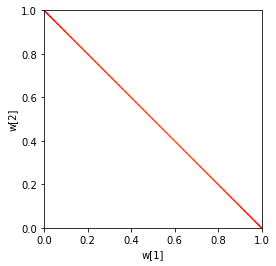

before normalize:  [0.9584952128329622, 0.9455326672880261, 0.93257012174309, 0.9196075761981539, 0.9066450306532178, 0.8940819402829325, 0.8832592493531679, 0.8718892465735903, 0.8597385562155169, 0.8485698040228472, 0.8376146917192873, 0.8265527594711725, 0.8154908272230577, 0.8047812616415427, 0.793366962726828, 0.7823050304787134, 0.7729605040513352, 0.7634022547469048, 0.7533869581959929, 0.7449630013770947, 0.7370410597202322, 0.7298787322723985, 0.7240506481413563, 0.7162240209278549, 0.7102875616602495, 0.7060025993315651, 0.7041263214765549, 0.7003824469079074, 0.6984548092460909, 0.6958596875576446, 0.6946805816958871, 0.6943020210813017, 0.6939234604667164, 0.696499455129363, 0.6960429409308517, 0.6976464077815334, 0.6992498746322149, 0.7015818241169216, 0.704782759115837, 0.7075622843830475, 0.7153877235456061, 0.7247143290786223, 0.7302206760726149, 0.738949617521905, 0.7477813630992596, 0.7555925718143288, 0.764051817396959, 0.7741223936392263, 0.7832951766479054, 0.79332

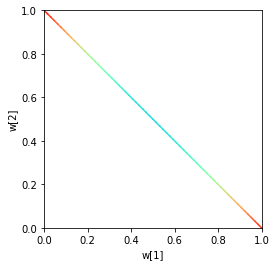

before normalize:  [0.8242332674771997, 0.814263579888048, 0.8037647847677304, 0.7925061003228681, 0.7803327341920484, 0.7676100287500739, 0.7548873233080993, 0.7433507310005696, 0.7340772528224698, 0.7248037746443701, 0.7136953092088315, 0.705179256902727, 0.6943016078496368, 0.6828761812584987, 0.6714507546673606, 0.6600253280762225, 0.6485999014850845, 0.6371744748939464, 0.6277158794523194, 0.6207265209622548, 0.6137371624721901, 0.6067478039821254, 0.5997584454920606, 0.5927690870019959, 0.584960765337558, 0.5749910777484063, 0.5672763273425143, 0.5625000000006585, 0.5513156013653897, 0.5479619616686298, 0.5500326288044393, 0.54895530439967, 0.5545885653865813, 0.5562417392711947, 0.5656296336048671, 0.5733739059888994, 0.5836181409585245, 0.5939158219509348, 0.6042135029433453, 0.6145111839357558, 0.6250000000006585, 0.6396963354848497, 0.6491527543846572, 0.6586091732844649, 0.6680655921842725, 0.6775220110840801, 0.6869784299838877, 0.6968926318750392, 0.7078991215147867, 0.718

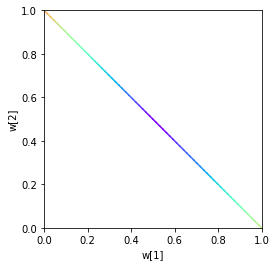

before normalize:  [0.8895394117653929, 0.8896087238986607, 0.8896780360319285, 0.8897473481651964, 0.8898166602984643, 0.8898784108122477, 0.88936318945328, 0.8888479680943121, 0.8883327467353443, 0.8878175253763767, 0.8873023040174088, 0.8867870826584411, 0.8862718612994732, 0.8857566399405055, 0.8852414185815376, 0.88472619722257, 0.8842109758636022, 0.8836957545046343, 0.8831805331456666, 0.8826653117866987, 0.8821500904277311, 0.8816348690687633, 0.8811196477097955, 0.8806044263508277, 0.8800892049918598, 0.8795739836328922, 0.8790587622739243, 0.8785435409149566, 0.8780283195559888, 0.877513098197021, 0.8769978768380533, 0.8764826554790854, 0.8759674341201177, 0.8754522127611499, 0.8749369914021821, 0.8744217700432144, 0.8739065486842466, 0.8733913273252787, 0.8728761059663109, 0.8723608846073432, 0.8718456632483755, 0.8713304418894077, 0.8708152205304398, 0.870299999171472, 0.8697847778125043, 0.8692695564535364, 0.8687543350945688, 0.8682391137356009, 0.8677238923766332, 0.8672

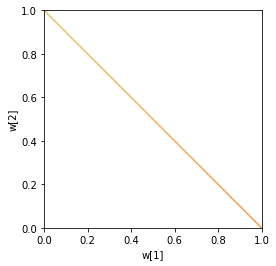

before normalize:  [0.9929912340374493, 1.0095704656488214, 1.0226922967897876, 1.0423611999771365, 1.0591528313078342, 1.074122220560643, 1.0884445987518028, 1.106582518501819, 1.1243031056524504, 1.1413464546526377, 1.1577022992262347, 1.1733607872240552, 1.1883124865584378, 1.2026508226856198, 1.2160599250266406, 1.2288389501410713, 1.240877768621185, 1.252169128732889, 1.2639502378185286, 1.275214274609231, 1.2844935070621761, 1.291736419792338, 1.2982012388043525, 1.3038840699329826, 1.309766194834077, 1.3148716454204736, 1.3191850664938867, 1.3227038598107503, 1.3254259057815472, 1.3273495647475686, 1.3284736779685826, 1.3283210407048396, 1.327044382163063, 1.324968361706857, 1.322094229853317, 1.3184237178720002, 1.3139590367420761, 1.3087028758205115, 1.302658401222105, 1.2958292539123373, 1.2896836622967964, 1.283844015597436, 1.2772310292691, 1.2698486867274765, 1.2617014348196687, 1.2527941811455814, 1.2431322911017633, 1.2327215846494963, 1.2215683328090654, 1.2096792538823

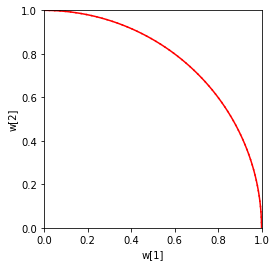

before normalize:  [0.9801384079071884, 0.9837379929108075, 0.9867450109318301, 0.9890124277397011, 0.9904195976725052, 0.9912301758738453, 0.9910599636928, 0.9900792758398678, 0.9885621248878553, 0.9893267476251693, 0.9888440784482261, 0.9901018718580037, 0.989836988454989, 0.9902956159108979, 0.9891668555291424, 0.98960173118341, 0.989477175641172, 0.989271260908142, 0.9871319524278573, 0.9847403003376194, 0.9841925085770526, 0.9815906832168599, 0.9767320149560288, 0.9774489760616099, 0.9774200386289726, 0.9782121875115064, 0.9798604677299538, 0.9813320738337608, 0.9822125621906601, 0.9821984205573896, 0.984132713220937, 0.9811751722483115, 0.981891332469981, 0.9815492139251362, 0.9815418846156618, 0.9820882299781273, 0.9828726228767966, 0.9821321105174334, 0.9819635213802864, 0.9799891210294158, 0.9805498597554816, 0.980308844253288, 0.982727876214039, 0.9855918859597127, 0.9847613798173562, 0.9852929043396653, 0.9859929157444387, 0.9866310741945958, 0.9871024990035988, 0.9882668105

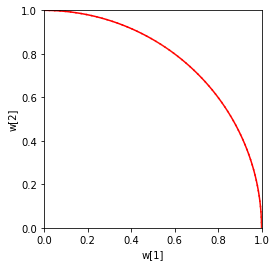

before normalize:  [0.8935358526598252, 0.8948045354639215, 0.8955342214747508, 0.8953751699106103, 0.89746755965446, 0.8994440963225021, 0.9008788414993008, 0.9017709309480095, 0.9019253204150584, 0.9011875274349562, 0.8999068927858993, 0.8980841878743144, 0.8957205106294848, 0.8928172848421991, 0.890443290167883, 0.88837374523285, 0.8857690771721225, 0.8826308549403457, 0.8789609688852463, 0.874761629608958, 0.8700353666364374, 0.857728610000272, 0.8505746399066546, 0.8432844019598329, 0.8354862010217052, 0.8271847344369234, 0.8183850026985462, 0.8090923064359299, 0.8033977297998578, 0.7922468207062072, 0.7840887725044188, 0.7843066707037462, 0.7794913622481667, 0.779591727117912, 0.7738322122414008, 0.772871689495652, 0.7770348358858519, 0.7883464276266062, 0.792426496878577, 0.7974088448213806, 0.8025855917096189, 0.8097153517927582, 0.8133286299650465, 0.8160861936978121, 0.8183521776229223, 0.8201252167963913, 0.8214042432057194, 0.8221884864132231, 0.8222710319510794, 0.82652236

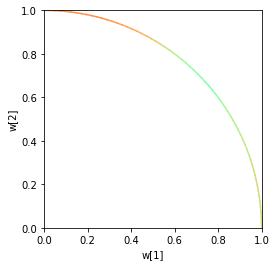

before normalize:  [0.8599955703237908, 0.8816511301237305, 0.9027756162499432, 0.9233563041018813, 0.9433807966427444, 0.9632162920981617, 0.982162559112281, 0.9999982008877671, 1.0176807501856266, 1.0347502866531086, 1.051196528239716, 1.0670095683444816, 1.082179881783334, 1.0966983305267124, 1.1105561692039736, 1.123745050371276, 1.1362570295397687, 1.1480845699610533, 1.159220547167041, 1.1696582532614634, 1.17939140096046, 1.1884141273798032, 1.1967209975664788, 1.2043070077725013, 1.211167588468981, 1.2172986070986398, 1.2226963705651093, 1.2273576274575126, 1.231279570008993, 1.2344598357880088, 1.2368965091213722, 1.23858812224818, 1.2395336562039387, 1.239184658138385, 1.237890336340457, 1.2358503556916183, 1.2330659449999326, 1.2295387814902845, 1.2252709897940828, 1.2202651406694625, 1.2145242494527553, 1.2080517742421646, 1.200851613814736, 1.192928105277879, 1.184286021456858, 1.1749305680198179, 1.1648673803420861, 1.1541025201116333, 1.1426424716777381, 1.13049413814505

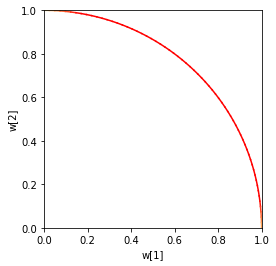

In [348]:
l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl)
l2_root=cell([0.0, np.pi/2, 0.0, np.pi/2], 0, pl, L2norm=True)
l1_all_c=[]
get_leaf_c(l1_root, l1_all_c)
l2_all_c=[]
get_leaf_c(l2_root, l2_all_c)

# for i, s in zip(range(3), ['u', 'r', 'd']):
for i, s in zip(range(3), ['u']):
    vmaxu=max([max(d[key][i]) for key in [('uni', 'l1'), ('corr', 'l1'), ('sphi', 'l1'), ('anti', 'l1'), ]])
    vminu=min([min(d[key][i]) for key in [('uni', 'l1'), ('corr', 'l1'), ('sphi', 'l1'), ('anti', 'l1'), ]])
    print('$', vmaxu, vminu)
#     draw2d_heat(l1_all_c, d['uni', 'l1'][i], vmin=vminu, vmax=vmaxu, f='uni_l1_'+s+'_'+str(pl)+'.png')
#     draw2d_heat(l1_all_c, d['sphi', 'l1'][i], vmin=vminu, vmax=vmaxu, f='sphi_l1_'+s+'_'+str(pl)+'.png')
#     draw2d_heat(l1_all_c, d['anti', 'l1'][i], vmin=vminu, vmax=vmaxu, f='anti_l1_'+s+'_'+str(pl)+'.png')
#     draw2d_heat(l1_all_c, d['corr', 'l1'][i], vmin=vminu, vmax=vmaxu, f='corr_l1_'+s+'_'+str(pl)+'.png')
#     draw2d_heatL2(l2_all_c, d['uni', 'l2'][i], vmin=vminu, vmax=vmaxu, f='uni_l2_'+s+'_'+str(pl)+'.png')
#     draw2d_heatL2(l2_all_c, d['sphi', 'l2'][i], vmin=vminu, vmax=vmaxu, f='sphi_l2_'+s+'_'+str(pl)+'.png')
#     draw2d_heatL2(l2_all_c, d['anti', 'l2'][i], vmin=vminu, vmax=vmaxu, f='anti_l2_'+s+'_'+str(pl)+'.png')
#     draw2d_heatL2(l2_all_c, d['corr', 'l2'][i], vmin=vminu, vmax=vmaxu, f='corr_l2_'+s+'_'+str(pl)+'.png')
    
    draw2d_heat(l1_all_c, d['uni', 'l1'][i], vmin=vminu, vmax=vmaxu)
    draw2d_heat(l1_all_c, d['sphi', 'l1'][i], vmin=vminu, vmax=vmaxu)
    draw2d_heat(l1_all_c, d['anti', 'l1'][i], vmin=vminu, vmax=vmaxu)
    draw2d_heat(l1_all_c, d['corr', 'l1'][i], vmin=vminu, vmax=vmaxu)
    draw2d_heatL2(l2_all_c, d['uni', 'l2'][i], vmin=vminu, vmax=vmaxu)
    draw2d_heatL2(l2_all_c, d['sphi', 'l2'][i], vmin=vminu, vmax=vmaxu)
    draw2d_heatL2(l2_all_c, d['anti', 'l2'][i], vmin=vminu, vmax=vmaxu)
    draw2d_heatL2(l2_all_c, d['corr', 'l2'][i], vmin=vminu, vmax=vmaxu)




In [294]:
import os
print(os.system('ls'))

0


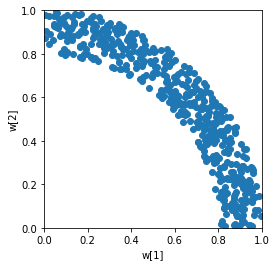

In [331]:
cardD=500
pdt_sph=gen_pdt_spherical(cardD, 2)
plot_pdt(pdt_sph)

In [177]:
pl=6
def getHeats(all_c, pdt, k=5):
    cal_heat(all_c, pdt, k)
    uheats=get_all_heat(all_c)
    rheats=get_all_heat(all_c, heat='rkskyband')
    dheats=get_all_heat(all_c, heat='rdominate')
    return [uheats, rheats, dheats]


d=dict()
for pdt, s in zip([pdt_sph], ['sph']):
    l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl)
    l2_root=cell([0.0, np.pi/2, 0.0, np.pi/2], 0, pl, L2norm=True)
    l1_all_c=[]
    get_leaf_c(l1_root, l1_all_c)
    l2_all_c=[]
    get_leaf_c(l2_root, l2_all_c)
    d[s, 'l1']=getHeats(l1_all_c, pdt)
    d[s, 'l2']=getHeats(l2_all_c, pdt)
    
l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl)
l2_root=cell([0.0, np.pi/2, 0.0, np.pi/2], 0, pl, L2norm=True)
l1_all_c=[]
get_leaf_c(l1_root, l1_all_c)
l2_all_c=[]
get_leaf_c(l2_root, l2_all_c)

for i, s in zip(range(3), ['u', 'r', 'd']):
    vmaxu=max([max(d[key][i]) for key in d])
    vminu=min([min(d[key][i]) for key in d])
    print('$', vmaxu, vminu)
    draw2d_heat(l1_all_c, d['sph', 'l1'][i], vmin=vminu, vmax=vmaxu, f='uni_l1_'+s+'_'+str(pl)+'.png')
    draw2d_heatL2(l2_all_c, d['sph', 'l2'][i], vmin=vminu, vmax=vmaxu, f='uni_l2_'+s+'_'+str(pl)+'.png')

NameError: name 'pdt_sph' is not defined

In [13]:
def cmul(n):
    ret=1
    for i in range(1, n+1):
        ret*=i
    return ret

def combination(n, m):
    if m>n:
        return 0
#     print(n ,m)
#     print(cmul(m))
#     print(n-m)
    return cmul(n)/cmul(m)/cmul(int(n-m))

def pow2(p):
    ret=1
    for i in range(p):
        ret*=2
    return ret
    
def cell_num(d, h):
    return combination(pow2(h)+d-1, pow2(h)-1) - combination(pow2(h), pow2(h)-d)

def cell_num2(d, h):
    ret=0
    for i in range(int(pow2(h)-(d-1)), int(pow2(h)-1+1)):
        ret+=combination(i+d-1, d-1) # *combination(d, pow2(h)-i)
    return ret

def v_num2(d, h):
    ret=0
    for i in range(int(pow2(h)-(d-1)), int(pow2(h)-1+1)):
        ret+=combination(i+d-1, d-1)*combination(d, pow2(h)-i)
    return ret
        
for d in range(2, 9):
    for h in range(1, 8):
        print(d, h, cell_num2(d, h))
        
for d in range(2, 9):
    for h in range(1, 8):
        print(d, h, v_num2(d, h))

2 1 2.0
2 2 4.0
2 3 8.0
2 4 16.0
2 5 32.0
2 6 64.0
2 7 128.0
3 1 4.0
3 2 16.0
3 3 64.0
3 4 256.0
3 5 1024.0
3 6 4096.0
3 7 16384.0
4 1 5.0
4 2 34.0
4 3 260.0
4 4 2056.0
4 5 16400.0
4 6 131104.0
4 7 1048640.0
5 1 6.0
5 2 56.0
5 3 736.0
5 4 11136.0
5 5 175616.0
5 6 2799616.0
5 7 44752896.0
6 1 7.0
6 2 84.0
6 3 1688.0
6 4 46256.0
6 5 1418592.0
6 6 44903104.0
6 7 1432966528.0
7 1 8.0
7 2 120.0
7 3 3424.0
7 4 159104.0
7 5 9254400.0
7 6 577558528.0
7 7 36728692736.0
8 1 9.0
8 2 165.0
8 3 6434.0
8 4 477444.0
8 5 51005448.0
8 6 6212960272.0
8 7 785216831520.0
2 1 4.0
2 2 8.0
2 3 16.0
2 4 32.0
2 5 64.0
2 6 128.0
2 7 256.0
3 1 12.0
3 2 48.0
3 3 192.0
3 4 768.0
3 5 3072.0
3 6 12288.0
3 7 49152.0
4 1 22.0
4 2 156.0
4 3 1208.0
4 4 9584.0
4 5 76512.0
4 6 611776.0
4 7 4893568.0
5 1 35.0
5 2 380.0
5 3 5360.0
5 4 82880.0
5 5 1314560.0
5 6 20986880.0
5 7 335605760.0
6 1 51.0
6 2 786.0
6 3 18948.0
6 4 557832.0
6 5 17464848.0
6 6 555793440.0
6 7 17760745536.0
7 1 70.0
7 2 1456.0
7 3 56896.0
7 4 3109120.0


In [21]:
import numpy as np
pdt_ta=[]
with open('./hotel.txt', 'r') as f:
    lines=f.readlines()
    for li in lines:
        li=li.strip()
        if li:
            vals=li.split(' ')
            vals=[float(val) for val in vals]
            pdt_ta.append(vals)
print(len(pdt_ta))
print(len(pdt_ta[0]))
pdt_ta=np.array(pdt_ta)        

1850
7


In [22]:
user_ta=[]
with open('./user.txt', 'r') as f:
    lines=f.readlines()
    for li in lines:
        li=li.strip()
        if li:
            vals=li.split(' ')
            vals=[float(val) for val in vals]
            user_ta.append(vals)
print(len(user_ta))
print(len(user_ta[0]))
user_ta=np.array(user_ta)           

137563
7


0 1


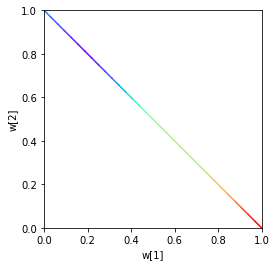

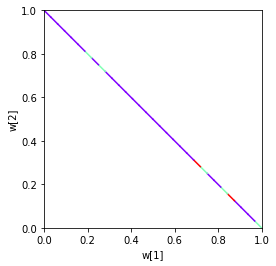

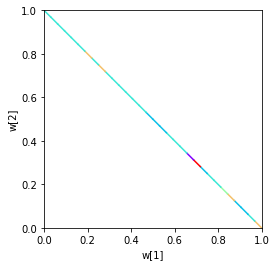

0 2


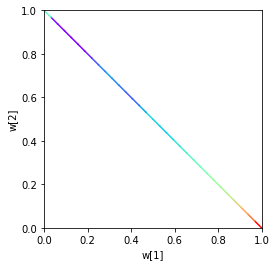

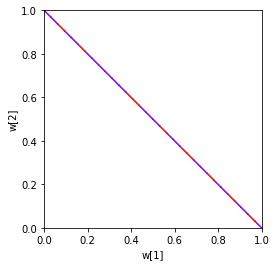

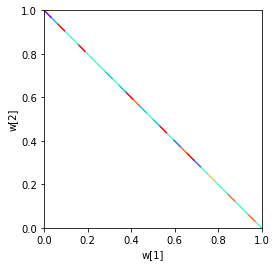

0 3


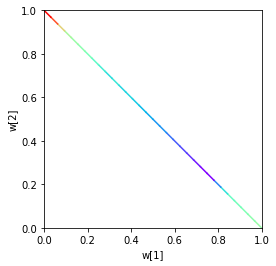

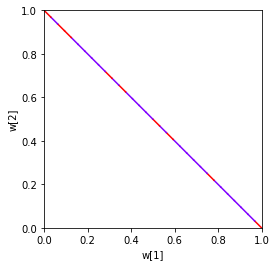

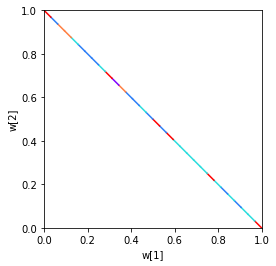

0 4


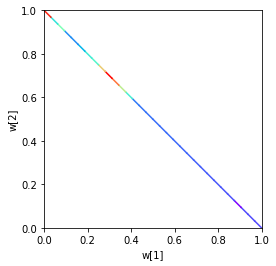

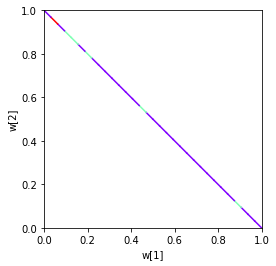

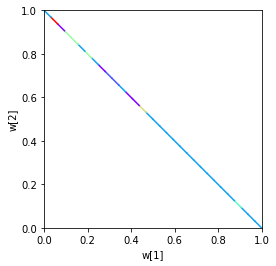

0 5


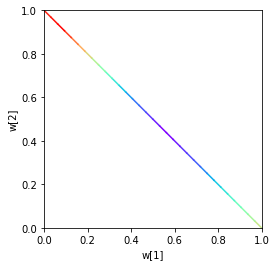

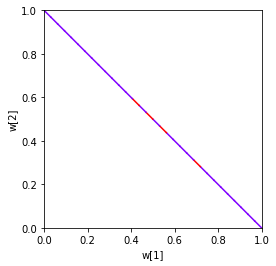

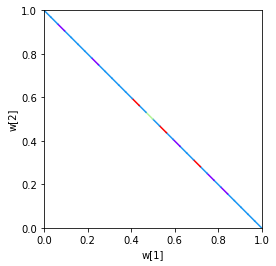

0 6


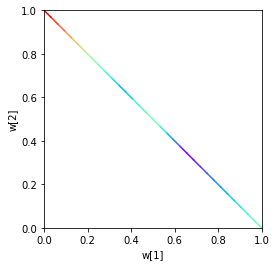

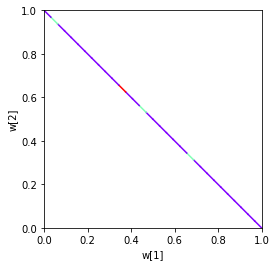

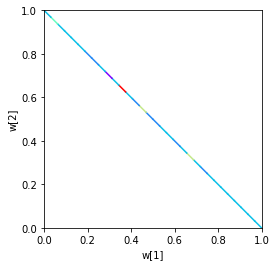

1 2


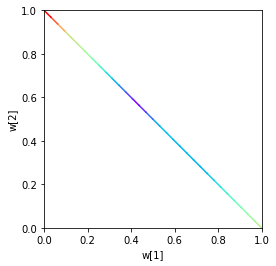

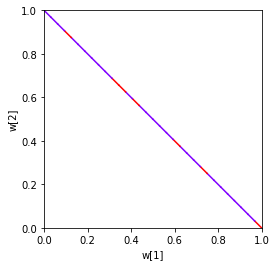

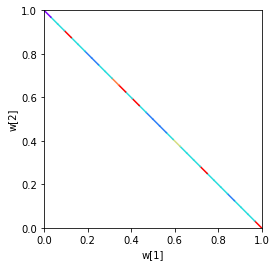

1 3


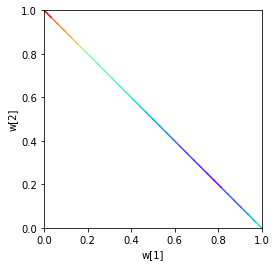

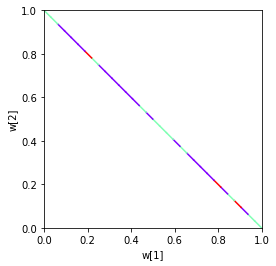

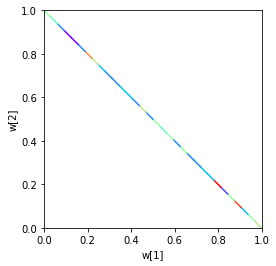

1 4


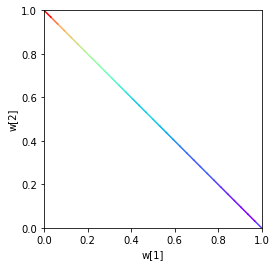

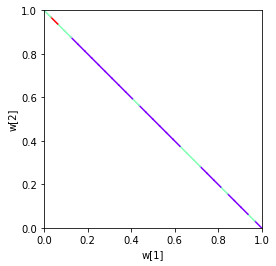

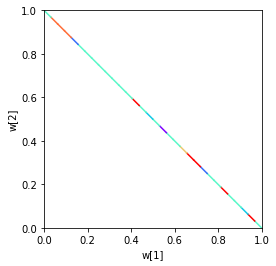

1 5


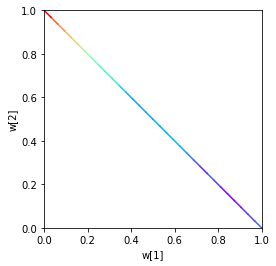

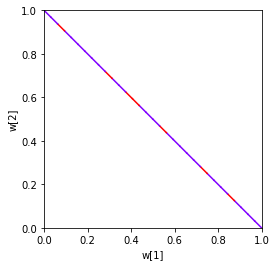

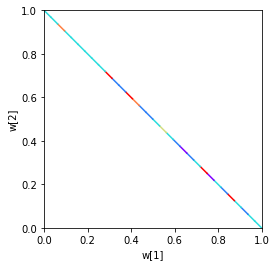

1 6


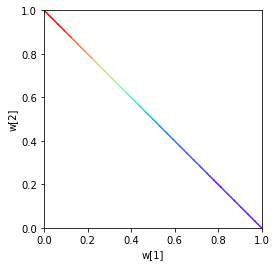

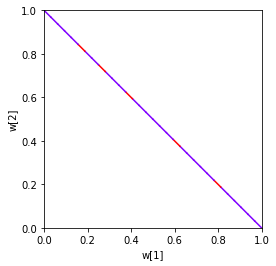

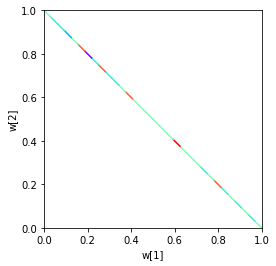

2 3


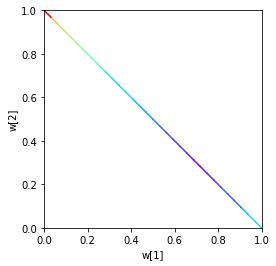

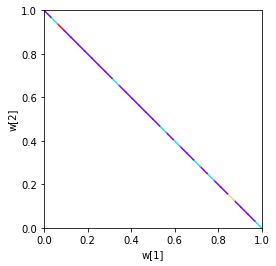

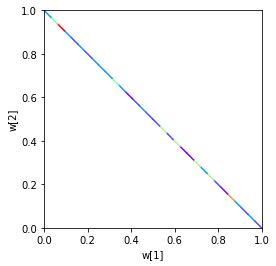

2 4


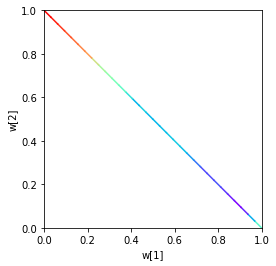

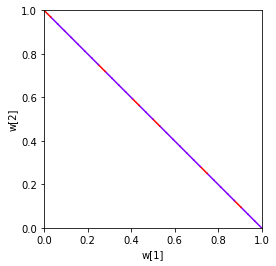

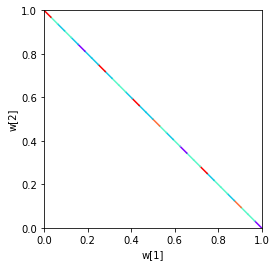

2 5


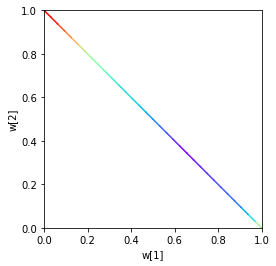

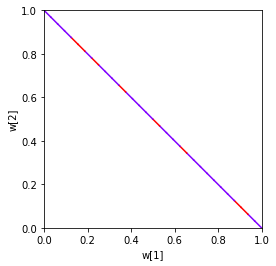

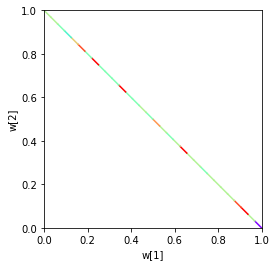

2 6


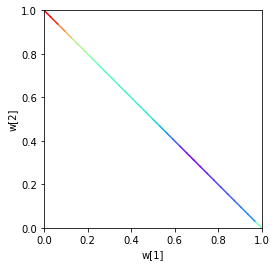

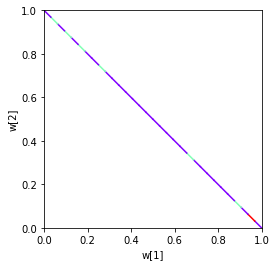

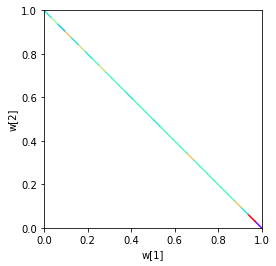

3 4


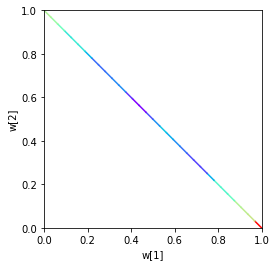

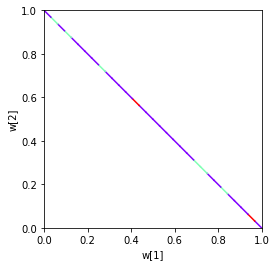

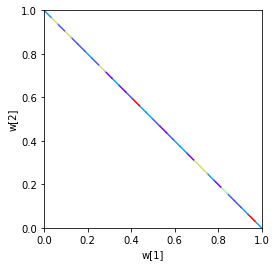

3 5


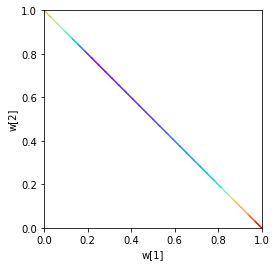

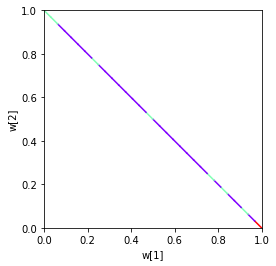

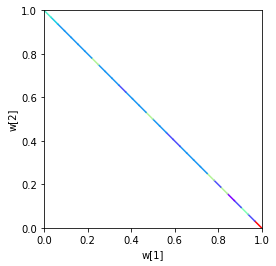

3 6


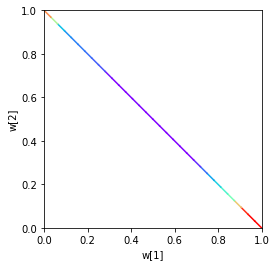

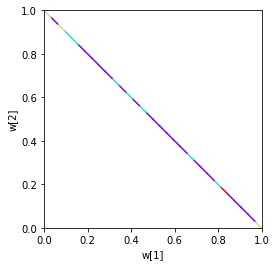

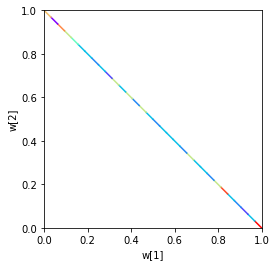

4 5


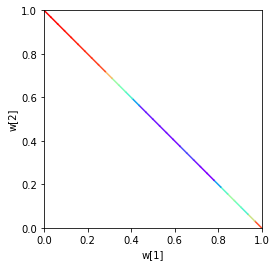

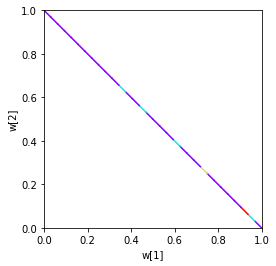

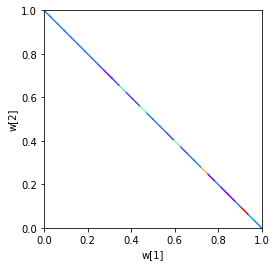

4 6


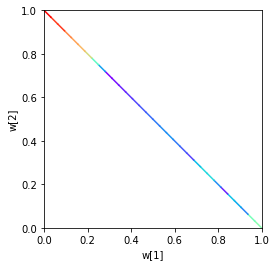

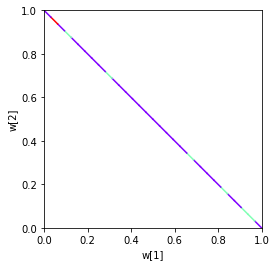

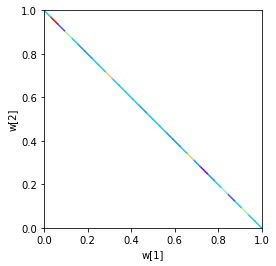

5 6


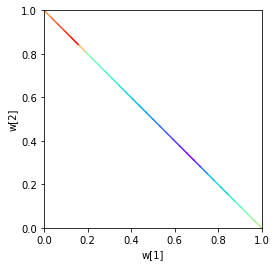

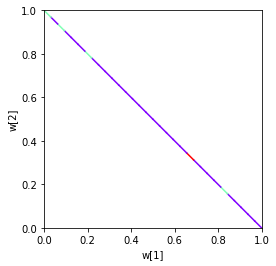

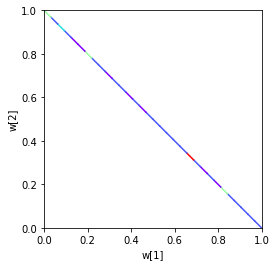

TypeError: list indices must be integers or slices, not str

In [49]:
pl=5
# def getHeats(all_c, pdt):
#     cal_heat(all_c, pdt, 5)
#     uheats=get_all_heat(all_c)
#     rheats=get_all_heat(all_c, heat='rkskyband')
#     dheats=get_all_heat(all_c, heat='rdominate')
#     return [uheats, rheats, dheats]

dn=dict()
dim=len(pdt_ta[0])
ss=set()
for i in range(dim):
    for j in range(i+1, dim):
        print(i, j)
        pdt=pdt_ta[:, [i, j]]
        s=str(i)+'_'+str(j)
        ss.add(s)
        l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl)
        l1_all_c=[]
        get_leaf_c(l1_root, l1_all_c)
        uh, rh, dh=getHeats(l1_all_c, pdt)
        dn[str(i)+'_'+str(j)]=[uh, rh, dh]
        for h in [uh, rh, dh]:
            vmaxu=max(h)
            vminu=min(h)
            draw2d_heat(l1_all_c, h, vmin=vminu, vmax=vmaxu)
        
    
l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl)
l1_all_c=[]
get_leaf_c(l1_root, l1_all_c)

for st in dn:
    for i, s in zip(range(3), ['u', 'r', 'd']):
        vmaxu=max(dn[st][i])
        vminu=min(dn[st][i])
        print('$', vmaxu, vminu)
#         draw2d_heat(l1_all_c, d[st][i], vmin=vminu, vmax=vmaxu, f='uni_l1_'+s+'_'+str(pl)+'.png')
        draw2d_heat(l1_all_c, dn[st][i], vmin=vminu, vmax=vmaxu)


('0_1', 'l1')
u 0.9896091076242212 0.9757692958823041


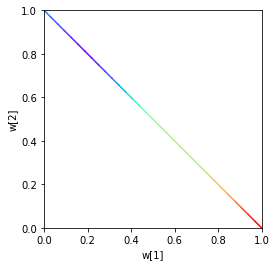

r 7 5


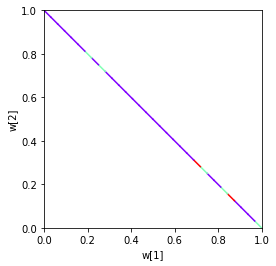

d 17 6


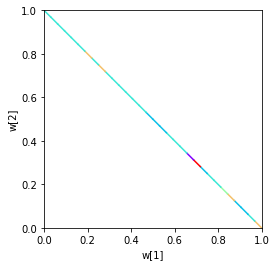

('0_2', 'l1')
u 0.9903172300409544 0.9826088197981743


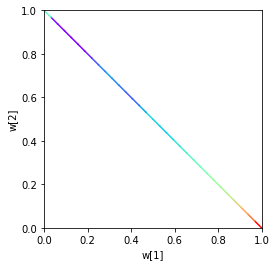

r 6 5


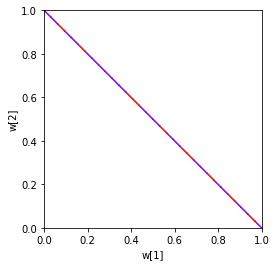

d 14 7


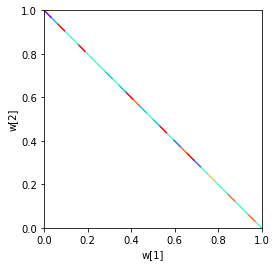

('0_3', 'l1')
u 0.9936000018999592 0.985761170206755


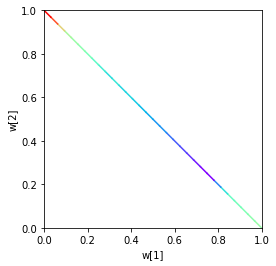

r 6 5


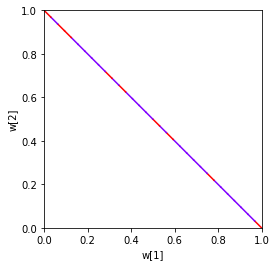

d 14 8


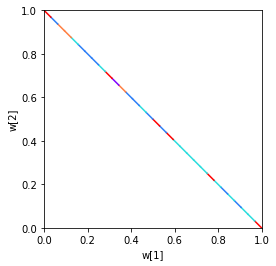

In [45]:
l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl)
l1_all_c=[]
get_leaf_c(l1_root, l1_all_c)

for st in d:
    print(st)
    for i, s in zip(range(1), ['u', 'r', 'd']):
        vmaxu=max(d[st][i])
        vminu=min(d[st][i])
        print(s, vmaxu, vminu)
#         draw2d_heat(l1_all_c, d[st][i], vmin=vminu, vmax=vmaxu, f='uni_l1_'+s+'_'+str(pl)+'.png')
        draw2d_heat(l1_all_c, d[st][i], vmin=vminu, vmax=vmaxu)

21
0_1
$ 0.9896091076242212 0.9757692958823041


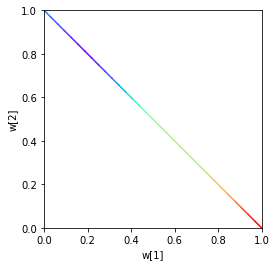

0_1
$ 7 5


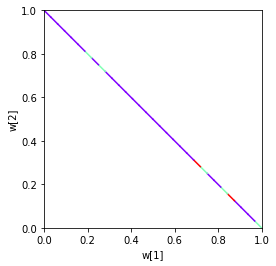

0_1
$ 17 6


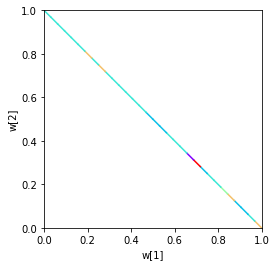

0_2
$ 0.9903172300409544 0.9826088197981743


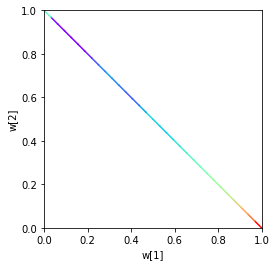

0_2
$ 6 5


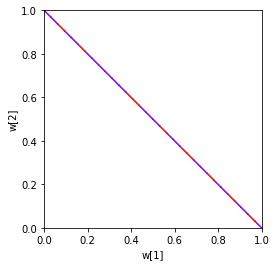

0_2
$ 14 7


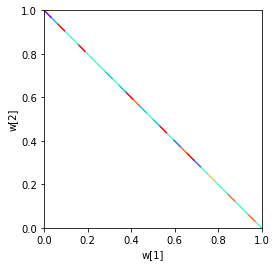

0_3
$ 0.9936000018999592 0.985761170206755


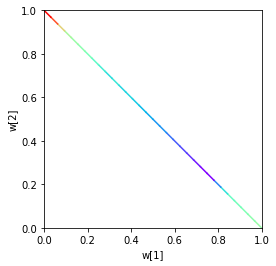

0_3
$ 6 5


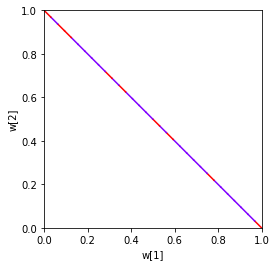

0_3
$ 14 8


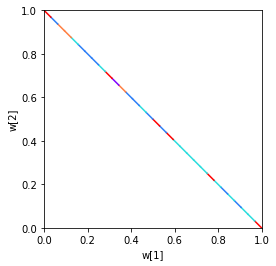

0_4
$ 0.9919500021825303 0.9907550146555336


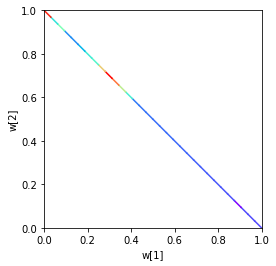

0_4
$ 7 5


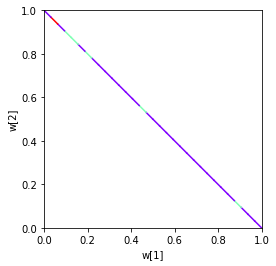

0_4
$ 17 8


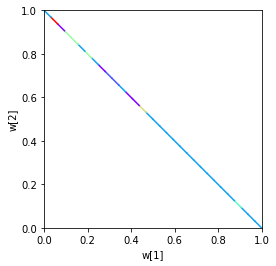

0_5
$ 0.9925927457262863 0.9869172439520097


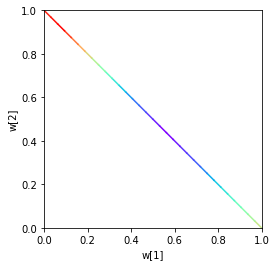

0_5
$ 6 5


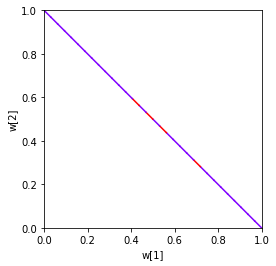

0_5
$ 14 9


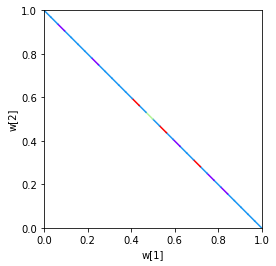

0_6
$ 0.9930423020254207 0.9883334206902181


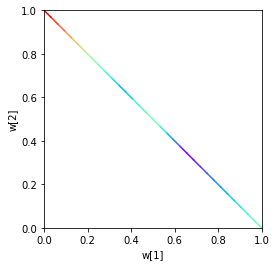

0_6
$ 7 5


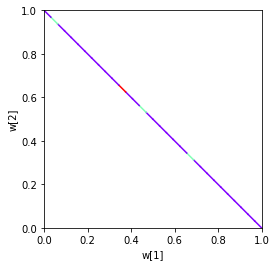

0_6
$ 18 7


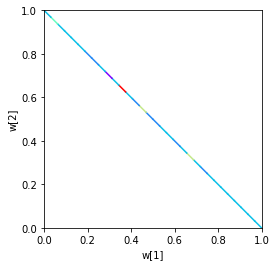

1_2
$ 0.9847925928365892 0.965552422583689


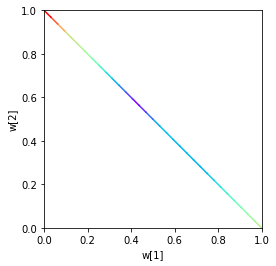

1_2
$ 6 5


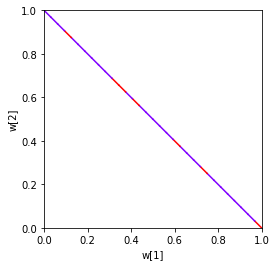

1_2
$ 14 8


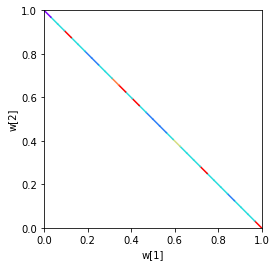

1_3
$ 0.9928190896335198 0.9683443753424628


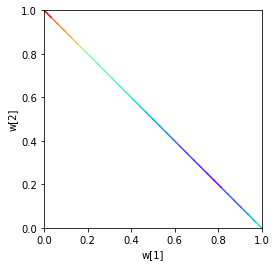

1_3
$ 7 5


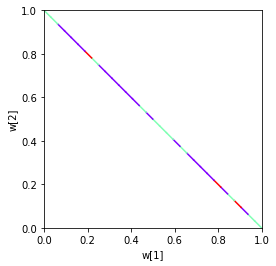

1_3
$ 18 7


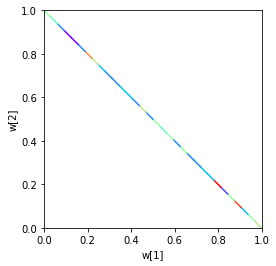

1_4
$ 0.9910451766996201 0.9759606041963883


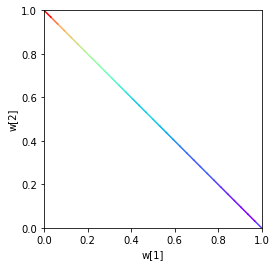

1_4
$ 7 5


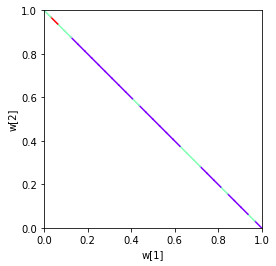

1_4
$ 14 7


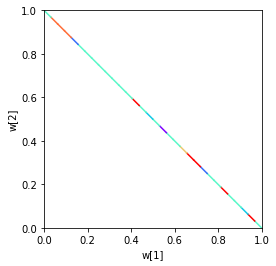

1_5
$ 0.9905675097369181 0.975917165100477


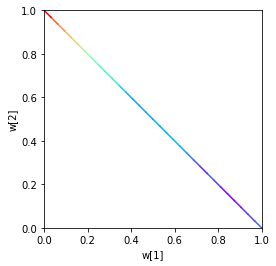

1_5
$ 6 5


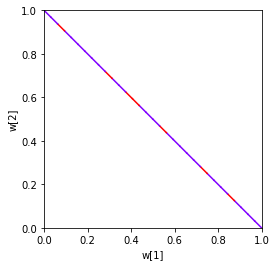

1_5
$ 14 8


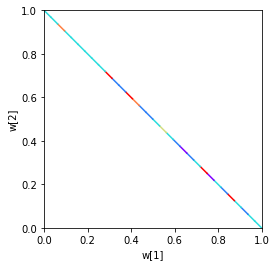

1_6
$ 0.9931702580106267 0.9780335941501496


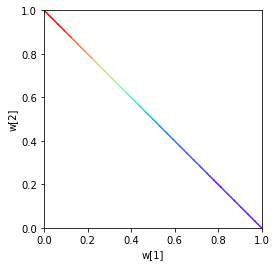

1_6
$ 6 5


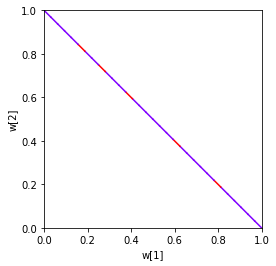

1_6
$ 14 6


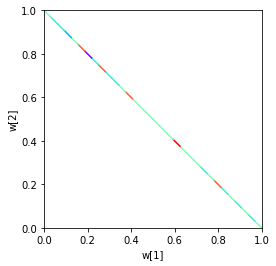

2_3
$ 0.9950000010550767 0.9766625024360609


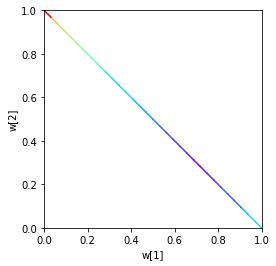

2_3
$ 8 5


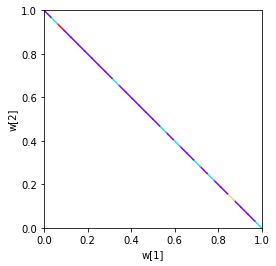

2_3
$ 18 8


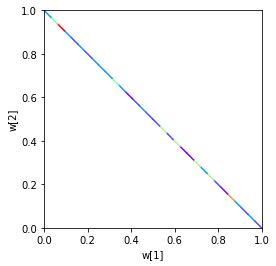

2_4
$ 0.9911250017865886 0.9834250017865886


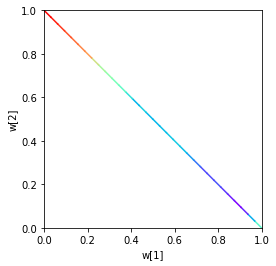

2_4
$ 6 5


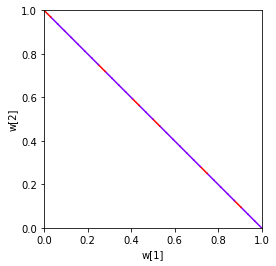

2_4
$ 14 7


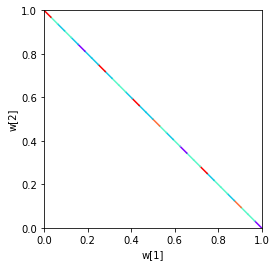

2_5
$ 0.991942385697623 0.9768600695273028


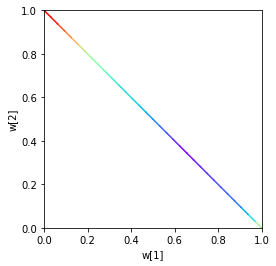

2_5
$ 6 5


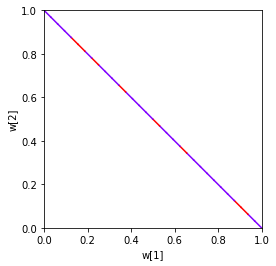

2_5
$ 14 4


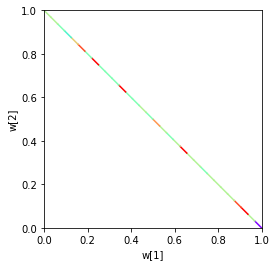

2_6
$ 0.9926416247336187 0.9770343926105718


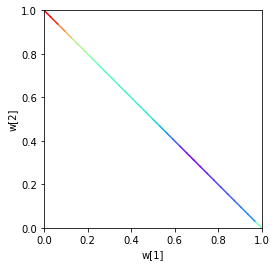

2_6
$ 7 5


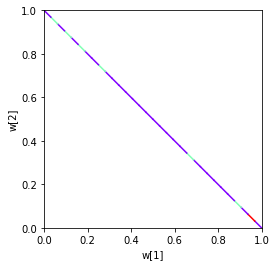

2_6
$ 18 4


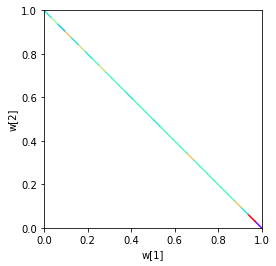

3_4
$ 0.9948375009986987 0.9869750024995856


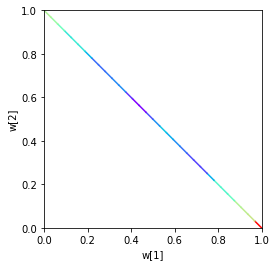

3_4
$ 7 5


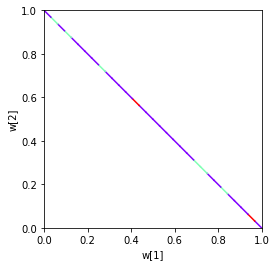

3_4
$ 17 8


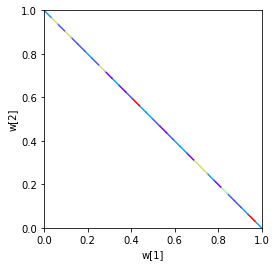

3_5
$ 0.9936000018999593 0.983497292759679


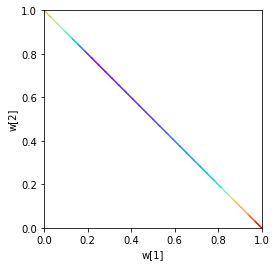

3_5
$ 7 5


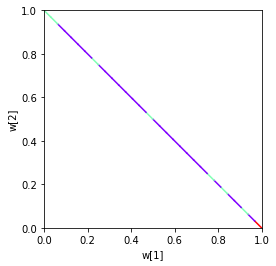

3_5
$ 18 8


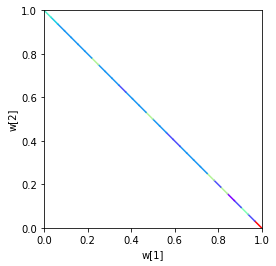

3_6
$ 0.9935736913657995 0.9834326036454322


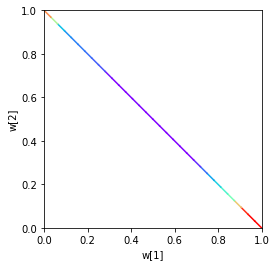

3_6
$ 8 5


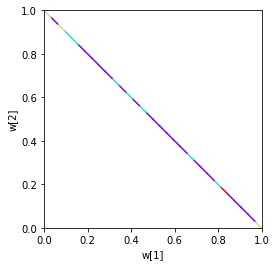

3_6
$ 18 7


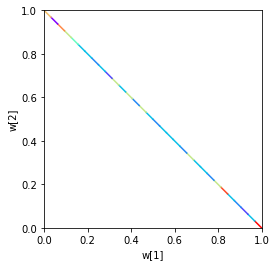

4_5
$ 0.9922923864689194 0.9887265785760497


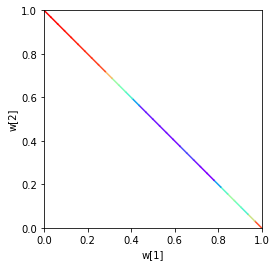

4_5
$ 8 5


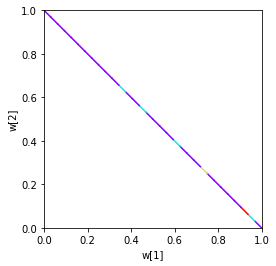

4_5
$ 20 8


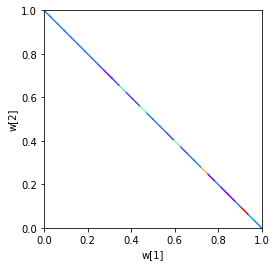

4_6
$ 0.9927877028280419 0.9902634834691386


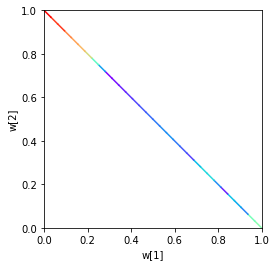

4_6
$ 7 5


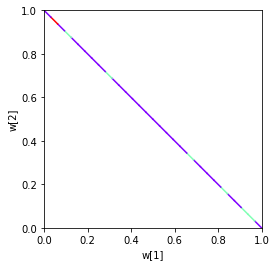

4_6
$ 17 7


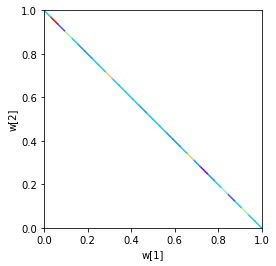

5_6
$ 0.9934110801616 0.9900459097489192


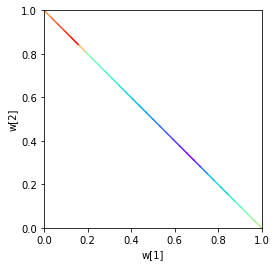

5_6
$ 7 5


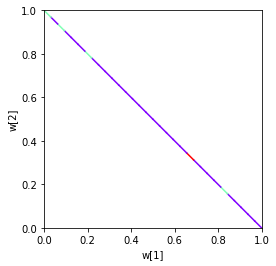

5_6
$ 18 9


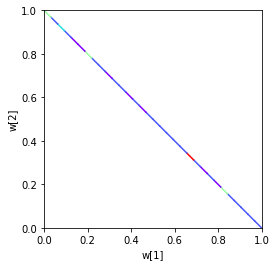

In [51]:
print(len(dn))
for st in dn:
    for i, s in zip(range(3), ['u', 'r', 'd']):
        print(st)
        vmaxu=max(dn[st][i])
        vminu=min(dn[st][i])
        print('$', vmaxu, vminu)
#         draw2d_heat(l1_all_c, d[st][i], vmin=vminu, vmax=vmaxu, f='uni_l1_'+s+'_'+str(pl)+'.png')
        draw2d_heat(l1_all_c, dn[st][i], vmin=vminu, vmax=vmaxu)


In [42]:
for key in d:
    print(d[key])

[[0.9896091076242212, 0.9889644051922373, 0.9883197027602532, 0.9876750003282692, 0.9866751296893186, 0.9861302848356812, 0.9856122353880123, 0.9850941859403435, 0.984451488168349, 0.9840580870450057, 0.9841532570304949, 0.9843839261060869, 0.9842331786652314, 0.9840824312243759, 0.9839316837835206, 0.9837809363426651, 0.9833244763718332, 0.9823435630466002, 0.9813626497213672, 0.9803817363961345, 0.9794008230709015, 0.9784199097456687, 0.9774389964204357, 0.9768053947776417, 0.976287345329973, 0.9757692958823041, 0.9759601802165317, 0.9763553686238484, 0.9767505570311652, 0.9771457454384819, 0.9775409338457987, 0.9779361222531154], [6, 5, 5, 5, 7, 6, 5, 5, 6, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5], [14, 10, 9, 9, 14, 12, 10, 10, 9, 17, 6, 10, 10, 10, 9, 9, 9, 10, 10, 10, 10, 10, 10, 14, 10, 14, 10, 10, 10, 10, 10, 10]]
[[0.9903172300409544, 0.9891254470641082, 0.9885612655920268, 0.9879970841199457, 0.9874836629543022, 0.9872138977258759, 0.98694413249744

In [188]:
def draw2d_heat_cs1(ax, cells, heats, mycm, vmin=None, vmax=None, f=None, norm=True, vi=1):
    """
    heat='utility' or heat='rkskyband' or heat='rdominate', the default is heat='utility'
    """
    # TODO1 how to define heatmap color and the normalize range
    # TODO2 how to plot ploygon on 2d and 3d

    if vmin is None:
        vmin=min(heats)
    if vmax is None:
        vmax=max(heats)
    if norm:
        normH=[(h-vmin)/(vmax-vmin) for h in heats]
    else:
        normH=heats
    Y=heats
#     hmax=max(heats)
#     hmin=min(heats)
    for cell,h, yi in zip(cells, normH, Y):
        x=[v[0] for v in cell.vertexes]
        y=[yi for _ in cell.vertexes]
        ax.plot(x, y, color=mycm(h))
    for cell, h, i, yi in zip(cells, normH, range(1, len(cells)), Y):
        x=[cell.vertexes[vi][0], cell.vertexes[vi][0]]
        y=[Y[i-1], Y[i]]
        ax.plot(x, y, color=mycm(h))
#     if not f:
#         plt.show()
#     else:
#         plt.savefig(f, format='png',  bbox_inches='tight')
#         draw2d_heat(cells, heats, vmin=vmin, vmax=vmax)

In [55]:
def inCell(cell, u):
    return cell.bounds[0]<=u[0] and u[0]<cell.bounds[1] 
    
def count_user(cells, users):
    ret=[0 for _ in range(len(cells))]
    for u in users:
        for ci in range(len(cells)):
            if inCell(cells[ci], u):
                ret[ci]+=1
                break
    return ret

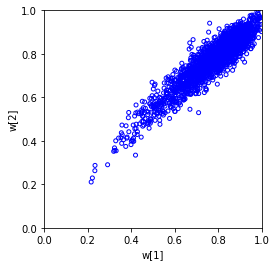

0_1


C:\anacondaanzhuang\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


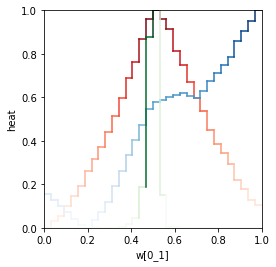

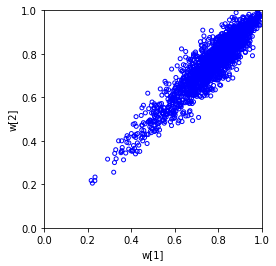

0_2


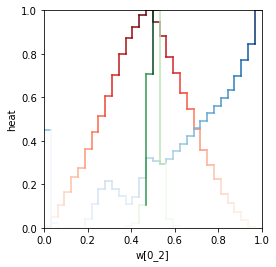

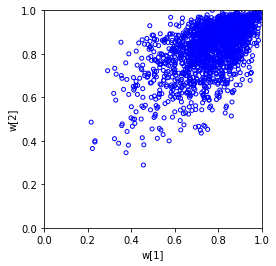

0_3


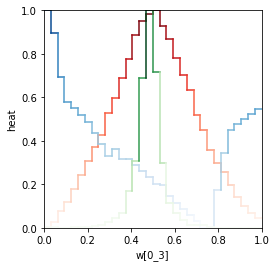

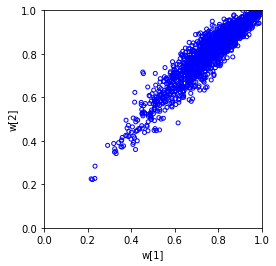

0_4


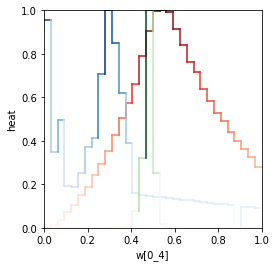

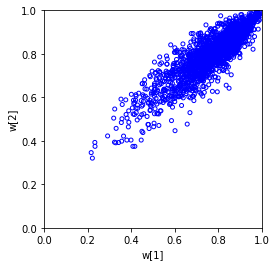

0_5


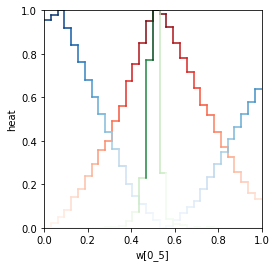

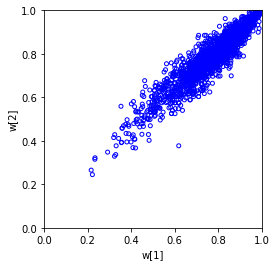

0_6


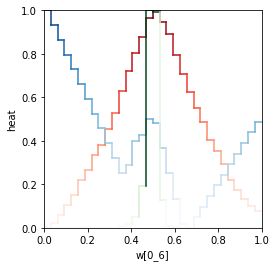

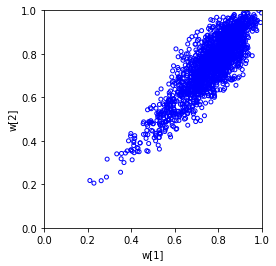

1_2


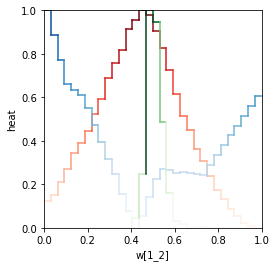

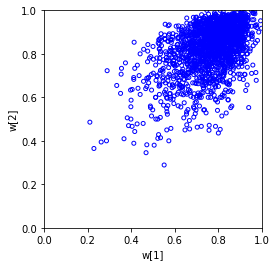

1_3


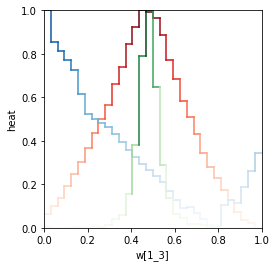

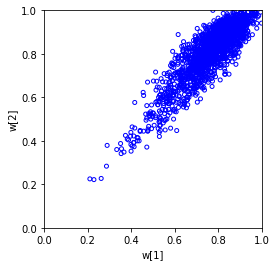

1_4


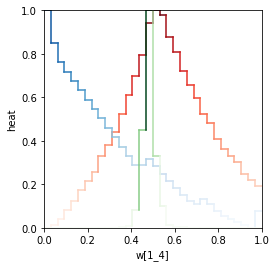

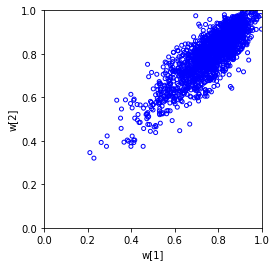

1_5


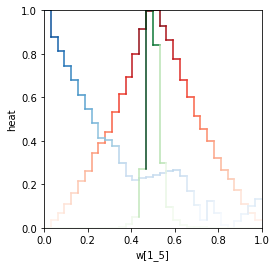

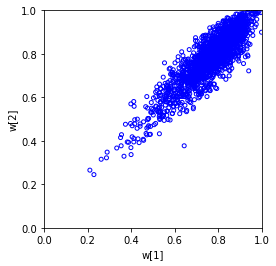

1_6


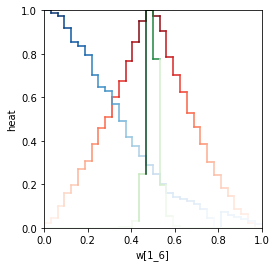

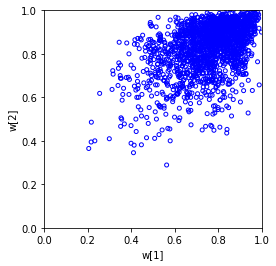

2_3


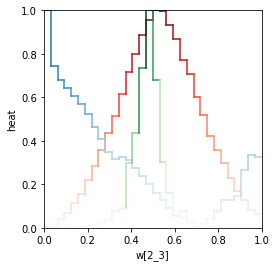

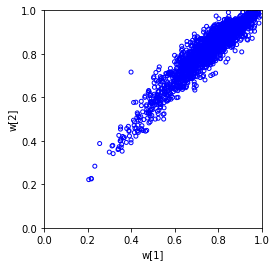

2_4


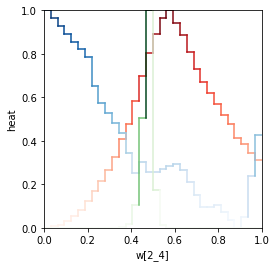

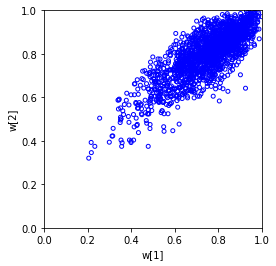

2_5


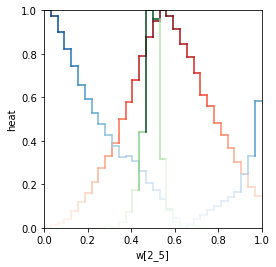

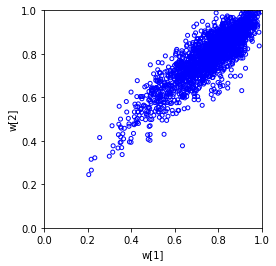

2_6


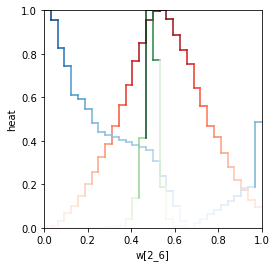

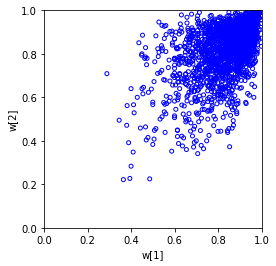

3_4


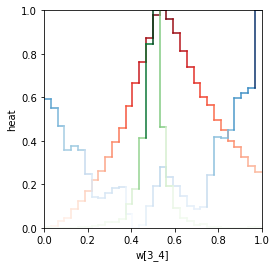

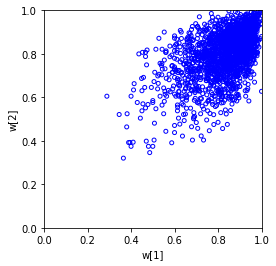

3_5


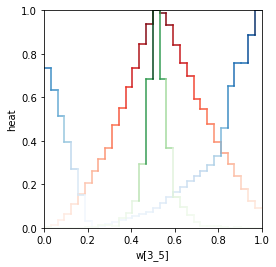

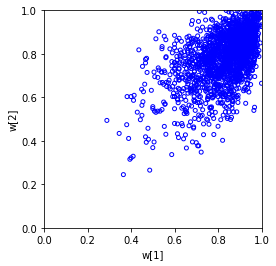

3_6


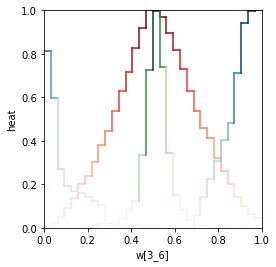

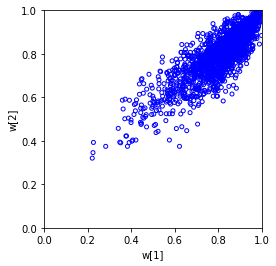

4_5


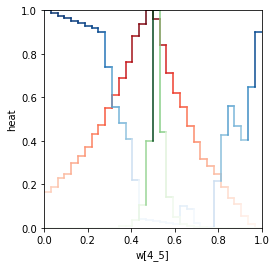

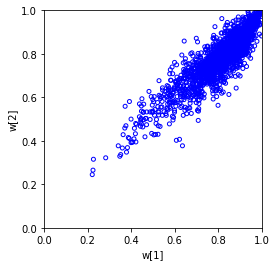

4_6


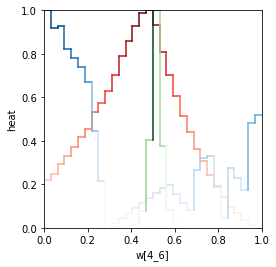

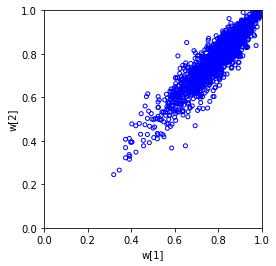

5_6


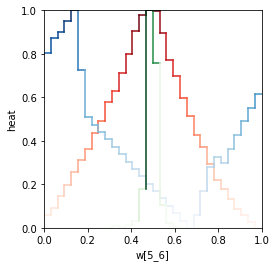

In [161]:
# case study 1
for key in dn:
    ds=key.split('_')
    users=user_ta[:, [int(ds[0]), int(ds[1])]]
    users=[u/sum(u) for u in users]
    usHeat=count_user(l1_all_c, users)
    
    pdts=pdt_ta[:, [int(ds[0]), int(ds[1])]]
    max0=max(pdts[:, 0])
    min0=min(pdts[:, 0])
    max1=max(pdts[:, 1])
    min1=min(pdts[:, 1])
    plot_pdt(pdts, s=16)
    pdts=[[(p[0]-min0)/(max0-min0), (p[1]-min1)/(max1-min1)] for p in pdts]
    pdts=[[p[0]/sum(p), p[1]/sum(p)] for p in pdts]
    psHeat=count_user(l1_all_c, pdts)
    
    fig, ax = plt.subplots()
    ax.set_xlabel('w['+key+']')
    ax.set_ylabel('heat')
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.set_aspect('equal', 'box')
    print(key)
    print(min(dn[key][0]), max(dn[key][0]))
    mycm= cm.get_cmap('Reds', 256)
    draw2d_heat_cs1(ax, l1_all_c, usHeat, mycm)
    mycm= cm.get_cmap('Blues', 256)
    draw2d_heat_cs1(ax, l1_all_c, dn[key][0], mycm)
#     mycm= cm.get_cmap('Greens', 256)
#     draw2d_heat_cs1(ax, l1_all_c, psHeat, mycm)
    

    plt.show()
    
    
# for c in l1_all_c:
#     print(c.bounds)

In [79]:
import numpy as np
import pandas as pd
udf=pd.DataFrame(user_ta)
print(udf.corr())

          0         1         2         3         4         5         6
0  1.000000 -0.171110 -0.246058 -0.209973 -0.129382 -0.152534 -0.162116
1 -0.171110  1.000000 -0.186968 -0.166028 -0.138219 -0.145843 -0.158539
2 -0.246058 -0.186968  1.000000 -0.211518 -0.134965 -0.160174 -0.201029
3 -0.209973 -0.166028 -0.211518  1.000000 -0.134183 -0.152338 -0.169036
4 -0.129382 -0.138219 -0.134965 -0.134183  1.000000 -0.147422 -0.141707
5 -0.152534 -0.145843 -0.160174 -0.152338 -0.147422  1.000000 -0.150312
6 -0.162116 -0.158539 -0.201029 -0.169036 -0.141707 -0.150312  1.000000


In [80]:
import numpy as np
import pandas as pd
pdf=pd.DataFrame(pdt_ta)
print(pdf.corr())

          0         1         2         3         4         5         6
0  1.000000  0.930028  0.927811  0.581283  0.939728  0.878668  0.931314
1  0.930028  1.000000  0.857802  0.514065  0.885387  0.845157  0.886693
2  0.927811  0.857802  1.000000  0.468668  0.939953  0.810792  0.862472
3  0.581283  0.514065  0.468668  1.000000  0.500612  0.543483  0.546807
4  0.939728  0.885387  0.939953  0.500612  1.000000  0.842667  0.892815
5  0.878668  0.845157  0.810792  0.543483  0.842667  1.000000  0.929381
6  0.931314  0.886693  0.862472  0.546807  0.892815  0.929381  1.000000


In [146]:
def get_all_heat(cells, heat='utility'):
    all_h=[]
    if heat=='utility':
        all_h=[c.uHeat for c in cells]
    elif heat=='rkskyband':
        all_h=[c.rHeat for c in cells]
    elif heat=='rdominate':
        all_h=[c.dHeat for c in cells]
    else:
        print('only support \'utility\', \'rkskyband\', \'rdominate\'')
    return all_h

import matplotlib.colors as colors
from matplotlib import cm

def draw2d_heat_cs2(ax, cells, heats, mycm, vmin=None, vmax=None, f=None):
    """
    heat='utility' or heat='rkskyband' or heat='rdominate', the default is heat='utility'
    """
    # TODO1 how to define heatmap color and the normalize range
    # TODO2 how to plot ploygon on 2d and 3d

    if vmin is None:
        vmin=min(heats)
    if vmax is None:
        vmax=max(heats)
    normH=[(h-vmin)/(vmax-vmin) for h in heats]
    
    for cell,h in zip(cells, normH):
        x=[v[0] for v in cell.vertexes]
        y=[v[1] for v in cell.vertexes]
#         print(h, cell.vertexes)
        ax.plot(x, y, color=mycm(h))
    
def plot_user_cs2(ax, user, save=False, fn='', format='pdf', label=['p[1]', 'p[2]'], color='blue', marker=4, s=32):
    user_a = np.array(user).T
    ax.scatter(user_a[0], user_a[1], color=color, s=s, marker=marker)

def plot_pdt_cs2(ax, pdt, save=False, fn='', format='pdf', color='blue', marker=4, s=32):
    plot_user_cs2(ax, pdt, save=save, fn=fn, format=format,label=['w[1]', 'w[2]'], color=color, marker=marker, s=s)

    

0 1
[[ 1.         -0.07149559]
 [-0.07149559  1.        ]]
[[1.         0.15117071]
 [0.15117071 1.        ]]


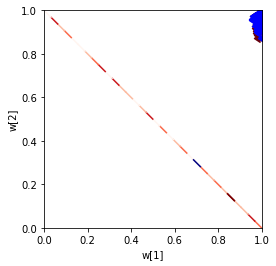

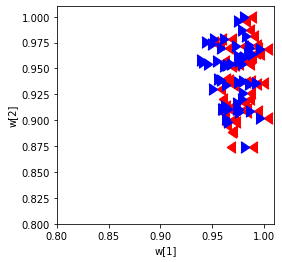

0 2
[[1.         0.33305515]
 [0.33305515 1.        ]]
[[1.         0.04580533]
 [0.04580533 1.        ]]


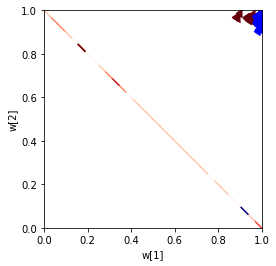

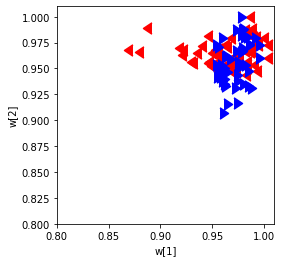

0 3
[[ 1.         -0.03009283]
 [-0.03009283  1.        ]]
[[ 1.         -0.26408895]
 [-0.26408895  1.        ]]


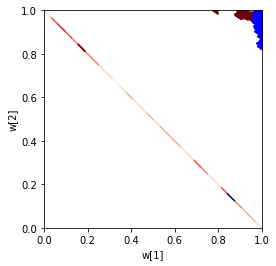

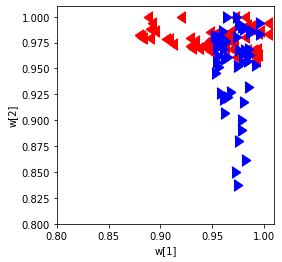

In [174]:
# case study 2
pl=5
k_2=50
d2_2=dict()
dim=len(pdt_ta[0])
ss_2=set()
cd_2=dict()
for i in range(0, 1):
    for j in range(i+1, 4):
        print(i, j)
        pdt=pdt_ta[:, [i, j]]
        s=str(i)+'_'+str(j)
        ss_2.add(s)
        pdt=np.array(pdt)
        l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl)
        l1_all_c=[]
        get_leaf_c(l1_root, l1_all_c)
        cal_cHeat(l1_all_c, pdt, k_2)
        rh=get_all_heat(l1_all_c, heat='rkskyband')
        d2_2[str(i)+'_'+str(j)]=rh
        cd_2[str(i)+'_'+str(j)]=l1_all_c
        fig, ax = plt.subplots()
        ax.set_xlabel('w[1]')
        ax.set_ylabel('w[2]')
        ax.set(xlim=(0, 1), ylim=(0, 1))
        ax.set_aspect('equal', 'box')
        mycm= cm.get_cmap('Reds', 256)
        for h in [rh]:
            vmaxu=max(h)
            vminu=min(h)
            draw2d_heat_cs2(ax, l1_all_c, h, mycm, vmin=vminu, vmax=vmaxu)
            maxrp=np.array(l1_all_c[np.argmax(h)].r_kskyband)
            minrp=np.array(l1_all_c[np.argmin(h)].r_kskyband)
            print(np.corrcoef(minrp.T))
            print(np.corrcoef(maxrp.T))
#             print(l1_all_c[np.argmax(h)].r_kskyband)
            plot_pdt_cs2(ax, l1_all_c[np.argmax(h)].r_kskyband, color=mycm(1.0), s=64)
            mycm= cm.get_cmap('jet', 256)
            draw2d_heat_cs2(ax, [l1_all_c[np.argmin(h)], l1_all_c[np.argmax(h)]], [h[np.argmin(h)], h[np.argmax(h)]], mycm, vmin=vminu, vmax=vmaxu)
            plot_pdt_cs2(ax, l1_all_c[np.argmin(h)].r_kskyband, color='blue', s=64)
        plt.show()
        
        fig, ax = plt.subplots()
        ax.set_xlabel('w[1]')
        ax.set_ylabel('w[2]')
        ax.set(xlim=(0.8, 1.01), ylim=(0.8, 1.01))
        ax.set_aspect('equal', 'box')
        plot_pdt_cs2(ax, l1_all_c[np.argmax(h)].r_kskyband, color='red', marker=4, s=128)
        plot_pdt_cs2(ax, l1_all_c[np.argmin(h)].r_kskyband, color='blue', marker=5, s=128)
        plt.show()
        
    



0 1
5 7


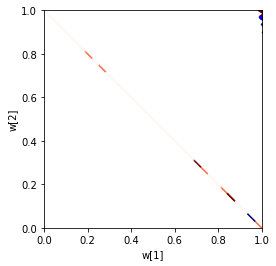

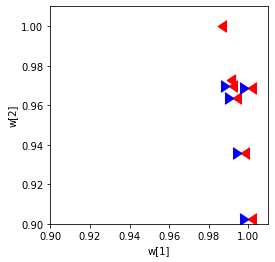

0 2
5 6


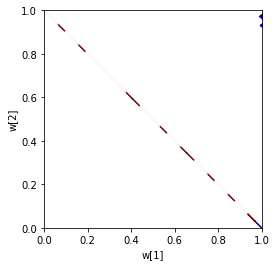

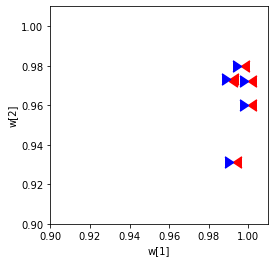

0 3
5 6


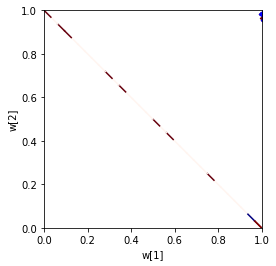

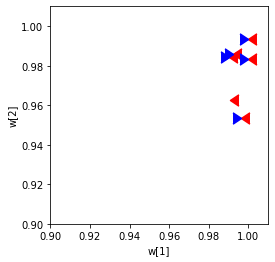

0 4
5 7


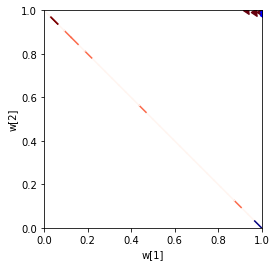

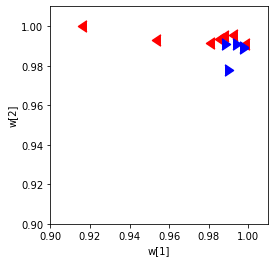

0 5
5 6


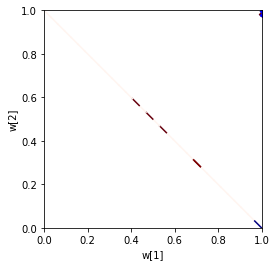

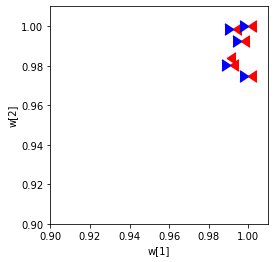

0 6
5 7


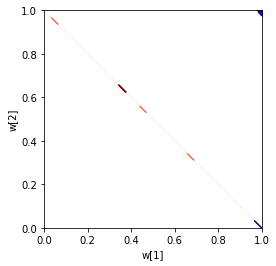

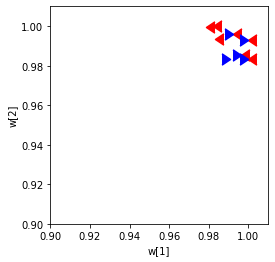

1 2
5 6


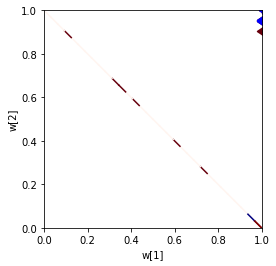

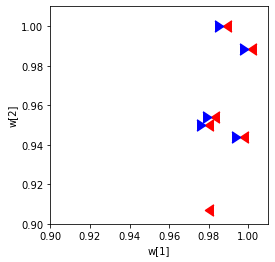

1 3
5 7


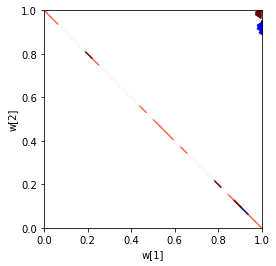

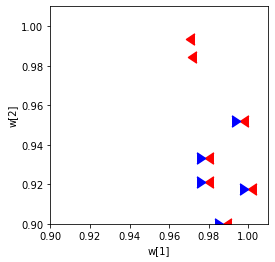

1 4
5 7


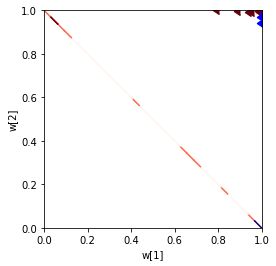

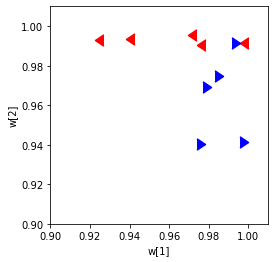

1 5
5 6


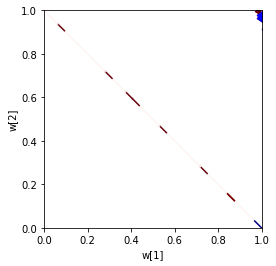

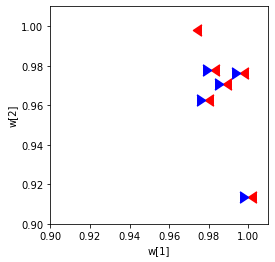

1 6
5 6


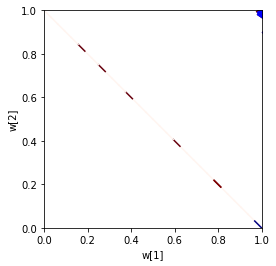

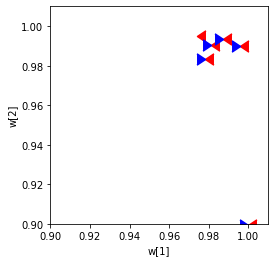

2 3
5 8


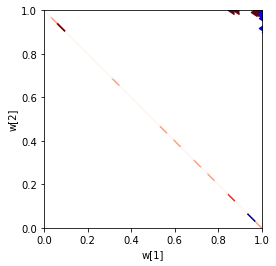

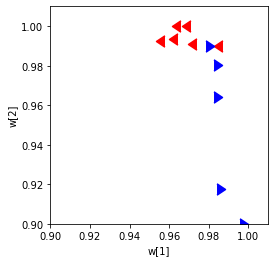

2 4
5 6


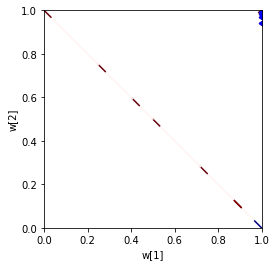

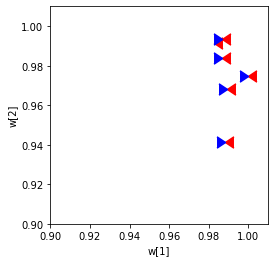

2 5
5 6


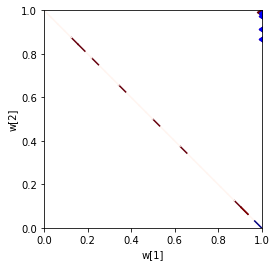

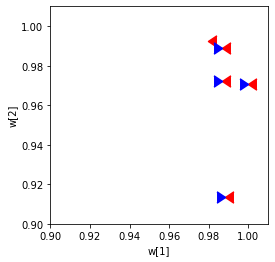

2 6
5 7


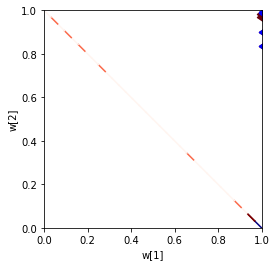

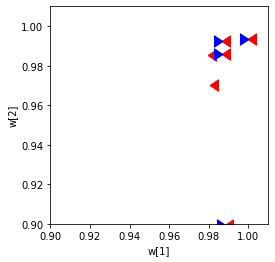

3 4
5 7


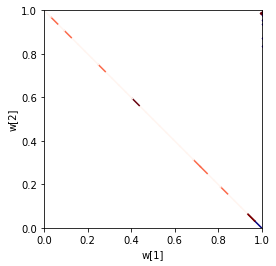

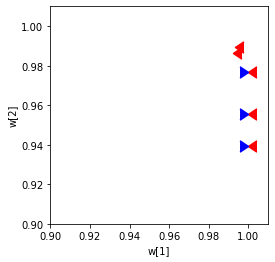

3 5
5 7


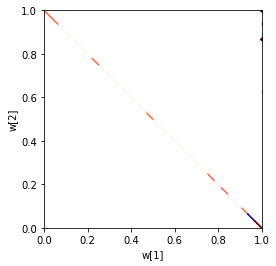

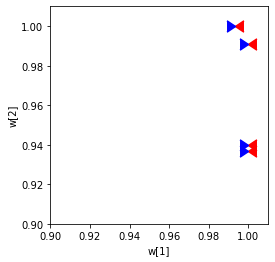

3 6
5 8


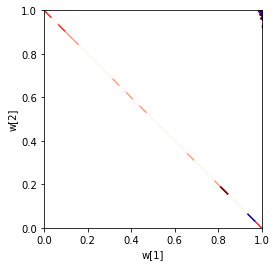

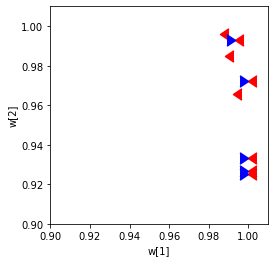

4 5
5 8


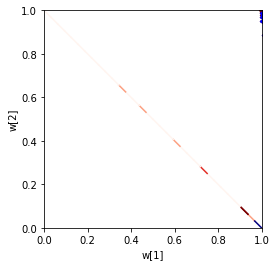

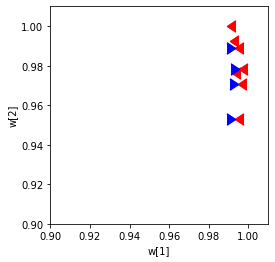

4 6
5 7


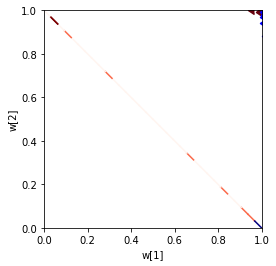

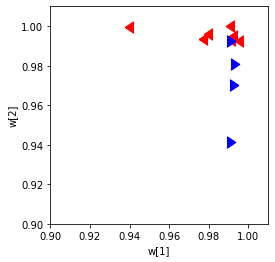

5 6
5 7


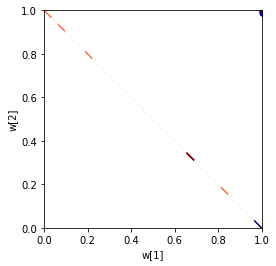

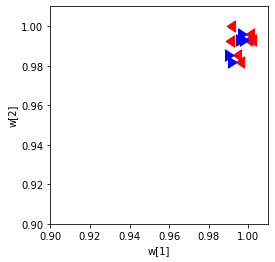

In [167]:
for i in range(dim):
    for j in range(i+1, dim):
        print(i, j)
        pdt=pdt_ta[:, [i, j]]
        s=str(i)+'_'+str(j)
        ss.add(s)
#         l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl)
#         l1_all_c=[]
#         get_leaf_c(l1_root, l1_all_c)
#         cal_cHeat(l1_all_c, pdt, k)
#         pdt=np.array(pdt)
#         rh=get_all_heat(l1_all_c, heat='rkskyband')
        rh=d2[str(i)+'_'+str(j)]
#         print(rh)
        l1_all_c=cd[str(i)+'_'+str(j)]
        fig, ax = plt.subplots()
        ax.set_xlabel('w[1]')
        ax.set_ylabel('w[2]')
        ax.set(xlim=(0, 1), ylim=(0, 1))
        ax.set_aspect('equal', 'box')
        mycm= cm.get_cmap('Reds', 256)
        for h in [rh]:
            vmaxu=max(h)
            vminu=min(h)
            print(vminu, vmaxu)
            draw2d_heat_cs2(ax, l1_all_c, h, mycm, vmin=vminu, vmax=vmaxu)
#             print(l1_all_c[np.argmax(h)].r_kskyband)
#             print(l1_all_c[np.argmin(h)].r_kskyband)
            plot_pdt_cs2(ax, l1_all_c[np.argmax(h)].r_kskyband, color=mycm(1.0), s=64)
            mycm= cm.get_cmap('jet', 256)
            draw2d_heat_cs2(ax, [l1_all_c[np.argmin(h)], l1_all_c[np.argmax(h)]], [h[np.argmin(h)], h[np.argmax(h)]], mycm, vmin=vminu, vmax=vmaxu)
            plot_pdt_cs2(ax, l1_all_c[np.argmin(h)].r_kskyband, color='blue', s=64)
            
        plt.show()
        
        fig, ax = plt.subplots()
        ax.set_xlabel('w[1]')
        ax.set_ylabel('w[2]')
        ax.set(xlim=(0.9, 1.01), ylim=(0.9, 1.01))
        ax.set_aspect('equal', 'box')
        plot_pdt_cs2(ax, l1_all_c[np.argmax(h)].r_kskyband, color='red', marker=4, s=128)
        plot_pdt_cs2(ax, l1_all_c[np.argmin(h)].r_kskyband, color='blue', marker=5, s=128)
        plt.show()

In [172]:
print([key for key in d2_2])

[]


0 1
0.11528837720708325


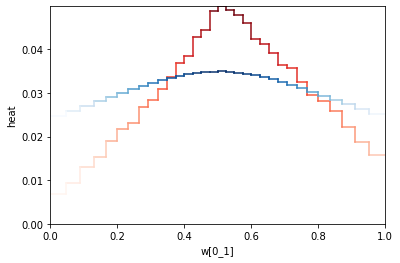

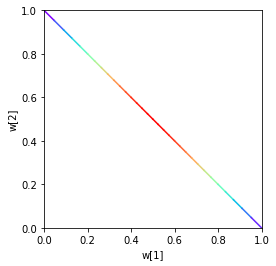

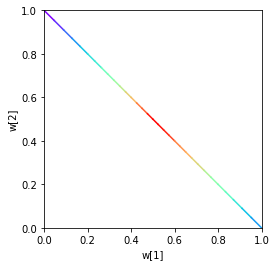

0 2
0.12794444659238624


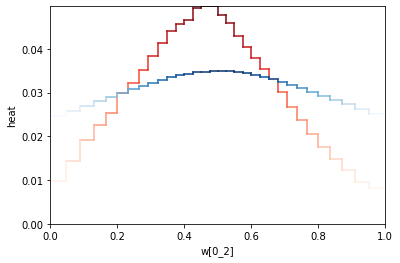

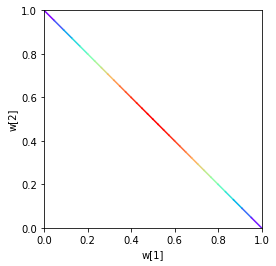

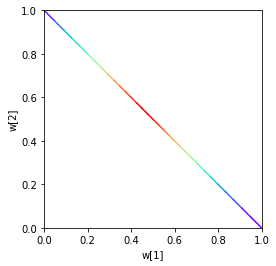

0 3
0.11371262876615082


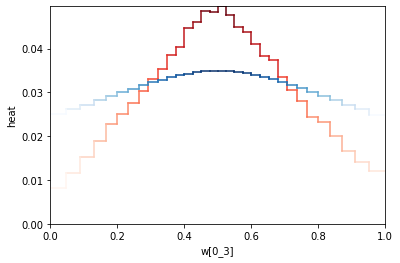

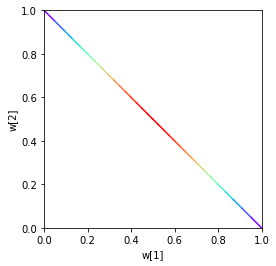

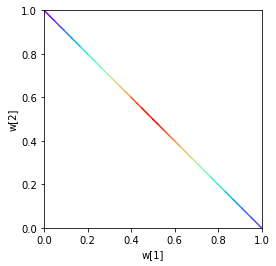

0 4


KeyError: '0_4'

In [196]:
from scipy.spatial import distance

pl=5

# dnl2=dict()
# dim=len(pdt_ta[0])
# ss=set()
for i in range(dim):
    for j in range(i+1, dim):
        print(i, j)
        pdt=pdt_ta[:, [i, j]]
        s=str(i)+'_'+str(j)
        ss.add(s)
        l2_root=cell([0.0, np.pi/2, 0.0, np.pi/2], 0, pl, L2norm=True)
        l2_all_c=[]
        get_leaf_c(l2_root, l2_all_c)
#         uh, rh, dh=getHeats(l2_all_c, pdt, k=15)
        [uh, rh, dh]=dnl2[str(i)+'_'+str(j)] #=[uh, rh, dh]
        users=user_ta[:, [i, j]]
        users=[u/sum(u) for u in users]
        usHeat=count_user(l2_all_c, users)
        for h in [uh]:
            vmaxu=max(h)
            vminu=min(h)
            print(distance.jensenshannon(uh, usHeat))
            fig, ax = plt.subplots()
            ax.set_xlabel('w['+s+']')
            ax.set_ylabel('heat')
            ax.set(xlim=(0, 1), ylim=(0, max([max(h)/sum(h), max(usHeat)/sum(usHeat)])))
#             ax.set_aspect('equal', 'box')
#             print(key)
#             print(min(dnl2[key][0]), max(dnl2[key][0]))
            mycm= cm.get_cmap('Reds', 256)
            usHeat=np.array(usHeat)/sum(usHeat)
            draw2d_heat_cs1(ax, l2_all_c, usHeat, mycm, vi=0)
            mycm= cm.get_cmap('Blues', 256)
            h=np.array(h)/sum(h)
            draw2d_heat_cs1(ax, l2_all_c, h, mycm, vi=0)
            draw2d_heat(l2_all_c, h)
            draw2d_heat(l2_all_c, usHeat)
            plt.show()
    


0 1
94 126
0.9637505062778455 1.3689576076891548
0.18381634531156318


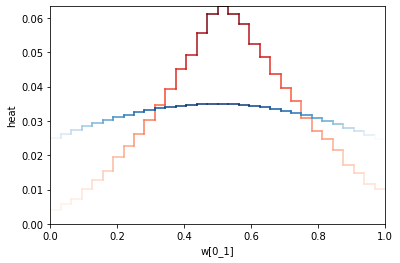

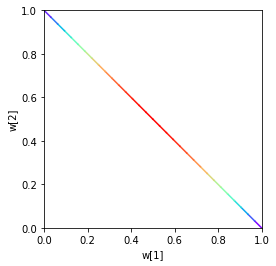

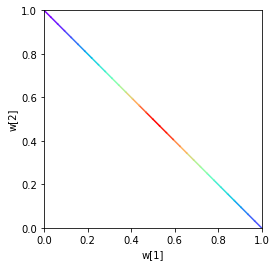

0 2
96 122
0.9722000000000001 1.3764538811226803
0.19719948914942573


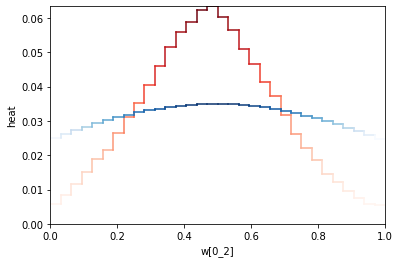

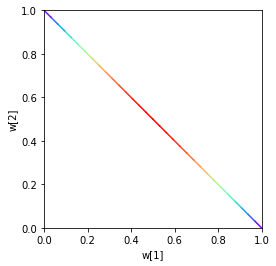

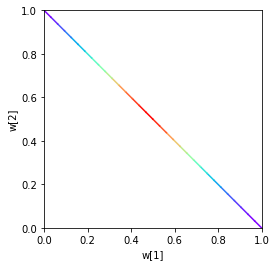

0 3
96 147
0.9835532994923859 1.3786578351130032
0.1861696004415168


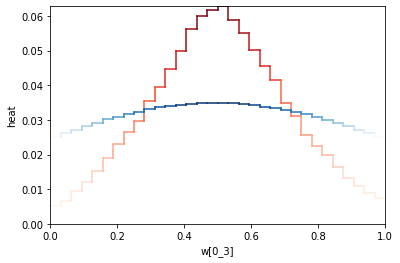

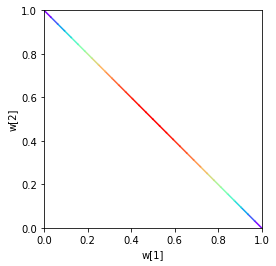

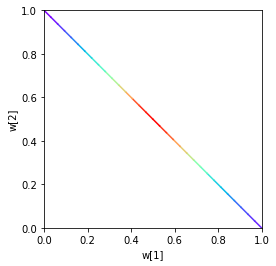

0 4
93 128
0.9835532994923859 1.3889574533798712
0.18804902832471465


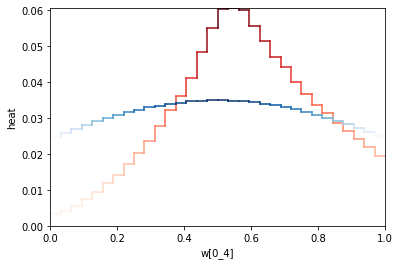

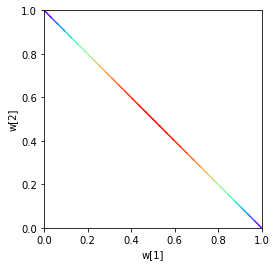

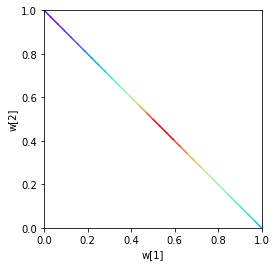

0 5
94 130
0.98285253177325 1.3879348550499744
0.18506476617216264


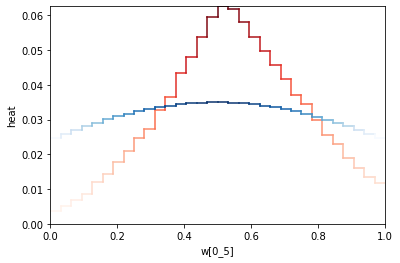

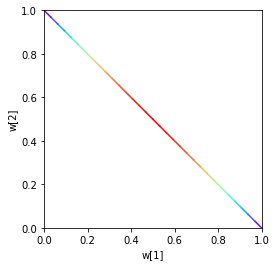

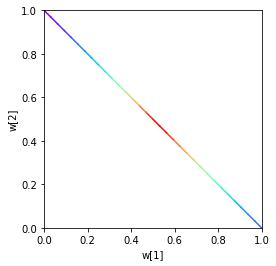

0 6
94 138
0.9835532994923859 1.3907271449185046
0.18841518921697792


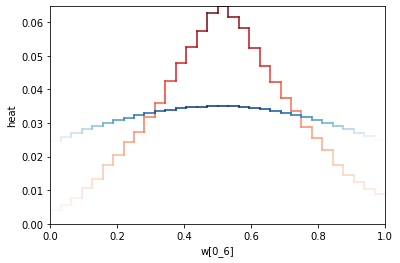

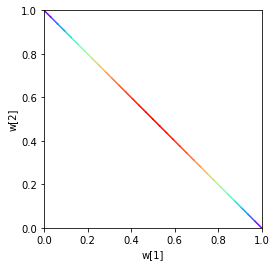

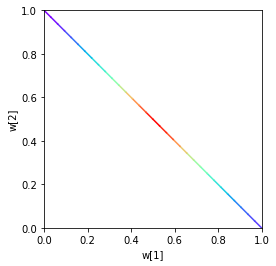

1 2
95 129
0.9637505062778454 1.3529796147363422
0.19884774647608652


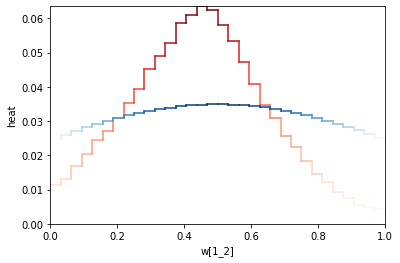

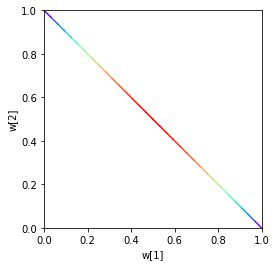

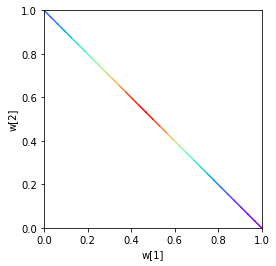

1 3
95 128
0.9637505062778454 1.351205737226005
0.17836427158802973


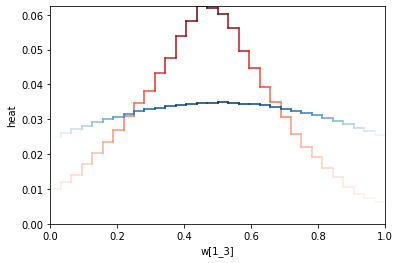

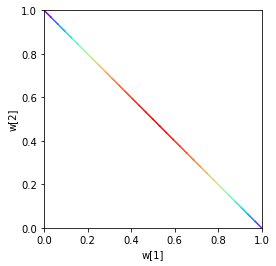

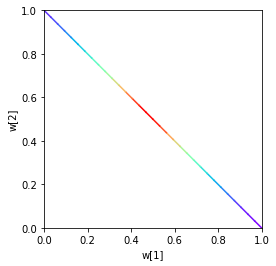

1 4
98 131


KeyboardInterrupt: 

In [202]:
from scipy.spatial import distance

pl=5

# dnl1=dict()
# dim=len(pdt_ta[0])
# ss=set()
for i in range(dim):
    for j in range(i+1, dim):
        print(i, j)
        pdt=pdt_ta[:, [i, j]]
        s=str(i)+'_'+str(j)
        ss.add(s)
        l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl, L2norm=False)
        l1_all_c=[]
        get_leaf_c(l1_root, l1_all_c)
#         uh, rh, dh=getHeats(l2_all_c, pdt, k=15)
        [uh, rh, dh]=dnl1[str(i)+'_'+str(j)] #=[uh, rh, dh]
        print(min(dh), max(dh))
        users=user_ta[:, [i, j]]
        users=[u/sum(u) for u in users]
        usHeat=count_user(l1_all_c, users)
        for h in [uh]:
            vmaxu=max(h)
            vminu=min(h)
            print(vminu, vmaxu)
            print(distance.jensenshannon(uh, usHeat))
            fig, ax = plt.subplots()
            ax.set_xlabel('w['+s+']')
            ax.set_ylabel('heat')
            ax.set(xlim=(0, 1), ylim=(0, max([max(h)/sum(h), max(usHeat)/sum(usHeat)])))
#             ax.set_aspect('equal', 'box')
#             print(key)
#             print(min(dnl2[key][0]), max(dnl2[key][0]))
            mycm= cm.get_cmap('Reds', 256)
            usHeat=np.array(usHeat)/sum(usHeat)
            draw2d_heat_cs1(ax, l1_all_c, usHeat, mycm, vi=1)
            mycm= cm.get_cmap('Blues', 256)
            h=np.array(h)/sum(h)
            draw2d_heat_cs1(ax, l1_all_c, h, mycm, vi=1)
            draw2d_heat(l1_all_c, h)
            draw2d_heat(l1_all_c, usHeat)
            plt.show()
    


0 1
0.9637505091957176 0.9825103417758629
0.21674564023745063


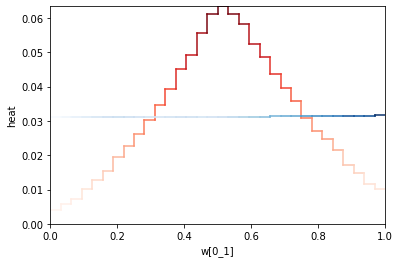

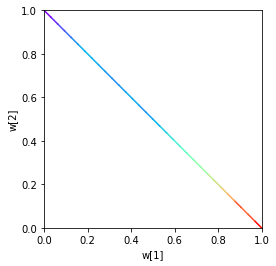

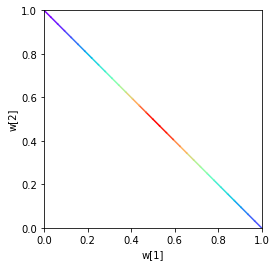

0 2
0.9698009227193948 0.9831472110041523
0.23194038224868152


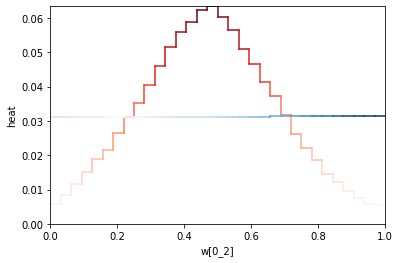

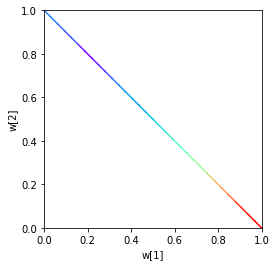

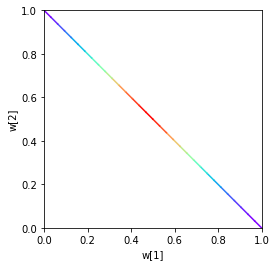

0 3
0.9733236069827733 0.9842000019025928
0.2211731719338152


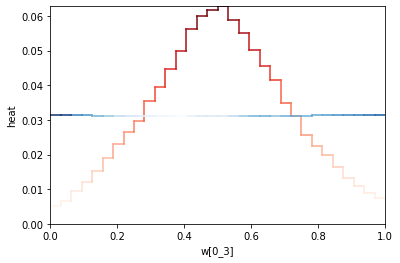

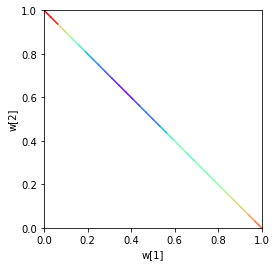

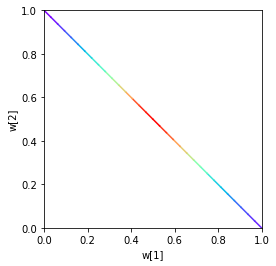

0 4
0.9819446729034904 0.9887329974261082
0.21583904953614258


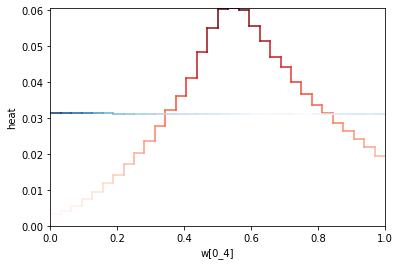

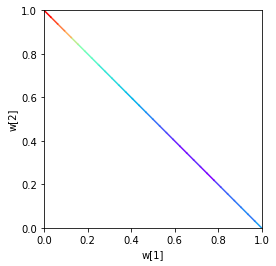

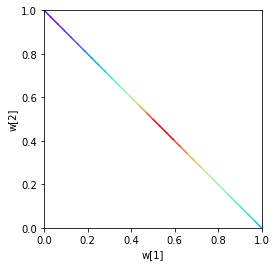

0 5


KeyboardInterrupt: 

In [200]:
from scipy.spatial import distance

pl=5

dnl1_2=dict()
dim=len(pdt_ta[0])
ss=set()
for i in range(dim):
    for j in range(i+1, dim):
        print(i, j)
        pdt=pdt_ta[:, [i, j]]
        s=str(i)+'_'+str(j)
        ss.add(s)
        l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl, L2norm=False)
        l1_all_c=[]
        get_leaf_c(l1_root, l1_all_c)
        uh, rh, dh=getHeats(l1_all_c, pdt, k=15)
        dnl1_2[str(i)+'_'+str(j)]=[uh, rh, dh]
        users=user_ta[:, [i, j]]
        users=[u/sum(u) for u in users]
        usHeat=count_user(l1_all_c, users)
        for h in [uh]:
            vmaxu=max(h)
            vminu=min(h)
            print(vminu, vmaxu)
            print(distance.jensenshannon(uh, usHeat))
            fig, ax = plt.subplots()
            ax.set_xlabel('w['+s+']')
            ax.set_ylabel('heat')
            ax.set(xlim=(0, 1), ylim=(0, max([max(h)/sum(h), max(usHeat)/sum(usHeat)])))
#             ax.set_aspect('equal', 'box')
#             print(key)
#             print(min(dnl2[key][0]), max(dnl2[key][0]))
            mycm= cm.get_cmap('Reds', 256)
            usHeat=np.array(usHeat)/sum(usHeat)
            draw2d_heat_cs1(ax, l1_all_c, usHeat, mycm, vi=1)
            mycm= cm.get_cmap('Blues', 256)
            h=np.array(h)/sum(h)
            draw2d_heat_cs1(ax, l1_all_c, h, mycm, vi=1)
            draw2d_heat(l1_all_c, h)
            draw2d_heat(l1_all_c, usHeat)
            plt.show()
    


0 1
0.9313368994022226 0.9579544210060738
0.2165688462132561


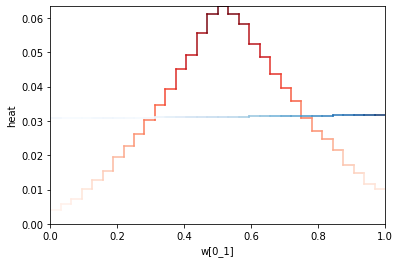

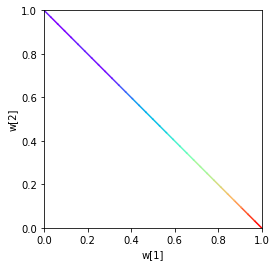

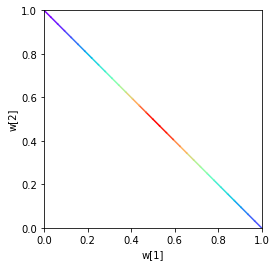

0 2
0.9502525724152294 0.9586010488147046
0.23178271156446906


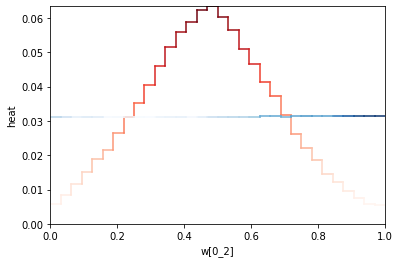

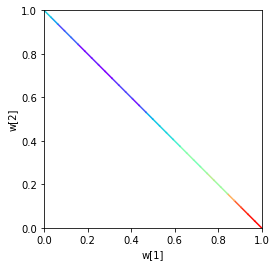

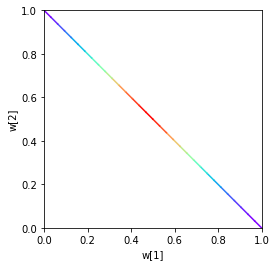

0 3


KeyboardInterrupt: 

In [201]:
from scipy.spatial import distance

pl=5

dnl1_3=dict()
dim=len(pdt_ta[0])
ss=set()
for i in range(dim):
    for j in range(i+1, dim):
        print(i, j)
        pdt=pdt_ta[:, [i, j]]
        s=str(i)+'_'+str(j)
        ss.add(s)
        l1_root=cell([0.0, 1.0, 0.0, 1.0], 0, pl, L2norm=False)
        l1_all_c=[]
        get_leaf_c(l1_root, l1_all_c)
        uh, rh, dh=getHeats(l1_all_c, pdt, k=50)
        dnl1_3[str(i)+'_'+str(j)]=[uh, rh, dh]
        users=user_ta[:, [i, j]]
        users=[u/sum(u) for u in users]
        usHeat=count_user(l1_all_c, users)
        for h in [uh]:
            vmaxu=max(h)
            vminu=min(h)
            print(vminu, vmaxu)
            print(distance.jensenshannon(uh, usHeat))
            fig, ax = plt.subplots()
            ax.set_xlabel('w['+s+']')
            ax.set_ylabel('heat')
            ax.set(xlim=(0, 1), ylim=(0, max([max(h)/sum(h), max(usHeat)/sum(usHeat)])))
#             ax.set_aspect('equal', 'box')
#             print(key)
#             print(min(dnl2[key][0]), max(dnl2[key][0]))
            mycm= cm.get_cmap('Reds', 256)
            usHeat=np.array(usHeat)/sum(usHeat)
            draw2d_heat_cs1(ax, l1_all_c, usHeat, mycm, vi=1)
            mycm= cm.get_cmap('Blues', 256)
            h=np.array(h)/sum(h)
            draw2d_heat_cs1(ax, l1_all_c, h, mycm, vi=1)
            draw2d_heat(l1_all_c, h)
            draw2d_heat(l1_all_c, usHeat)
            plt.show()
    
